# Lung cancer prediction using Image-Segmentation, Equalization and Transfer learning

1. Proposed methodology
2. Data Pre-processing
3. Comparison between processed and unprocessed image
4. Splitting the processed images
5. Neural nets
    - CNN
    - VGG16
    - VGG19
    - MobileNet
    - ResNet50
    - Xception
    - InceptionV3
6. Example: Prediction vs Truth
7. Comparative analysis of the models


**Importing the necessary libraries**

In [ ]:
!pip install split-folders

In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import tensorflow.keras.backend as K
import splitfolders
import pandas as pd
import numpy as np
import seaborn as sns

**Data Pre-processing**

**Histogram Equalization**

Histogram Equalization is a computer image processing technique used to improve contrast in images. It accomplishes this by effectively spreading out the most frequent intensity values, i.e. stretching out the intensity range of the image. This method usually increases the global contrast of images when its usable data is represented by close contrast values. This allows for areas of lower local contrast to gain a higher contrast.

**Threshold Segmentation**

Thresholding is a type of image segmentation, where we change the pixels of an image to make the image easier to analyze. In thresholding, we convert an image from colour or grayscale into a binary image, i.e., one that is simply black and white. Most frequently, we use thresholding as a way to select areas of interest of an image, while ignoring the parts we are not concerned with.

***We will preprocess our raw data by histogram equalization and then segment it using thresholding***

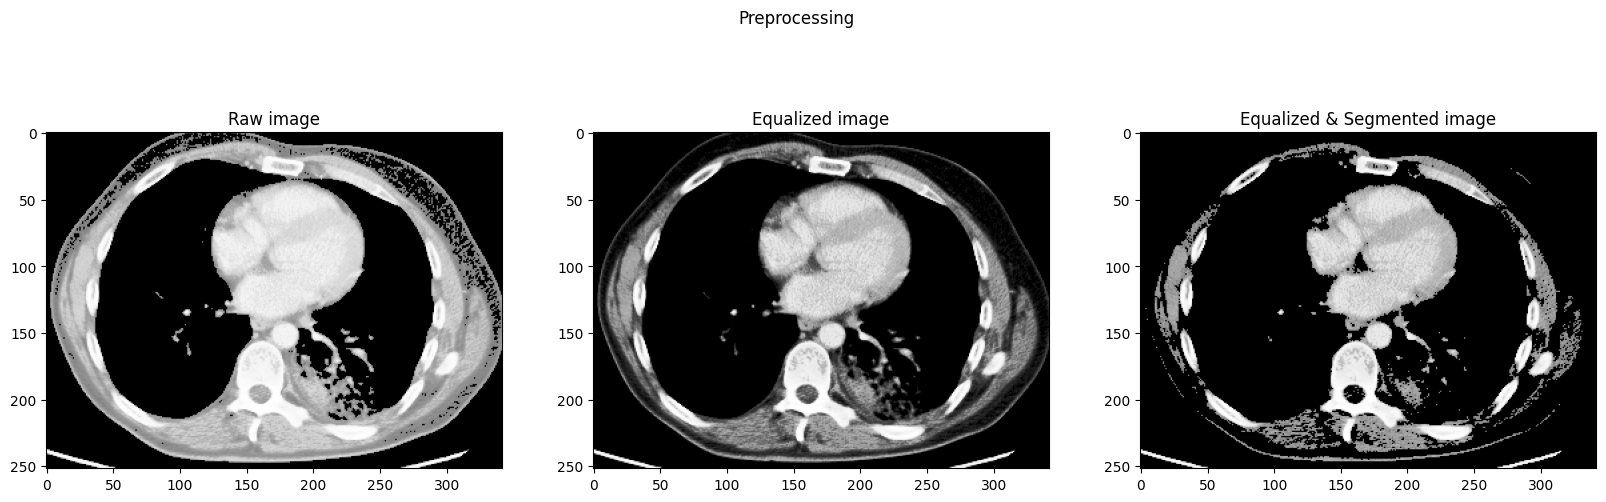

In [ ]:
img = cv2.imread('/content/drive/MyDrive/BIO_Project/rawData/squamous.cell.carcinoma/squamous.cell.carcinoma1.png', 0)
equalizedImage = cv2.equalizeHist(img)
e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Raw image')

ax2 = plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(equalizedImage, cv2.COLOR_BGR2RGB))
ax2.set_title('Equalized image')

ax3 = plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
ax3.set_title('Equalized & Segmented image')

plt.suptitle('Preprocessing')

plt.show()

In [ ]:
print(os.getcwd(), os.listdir())
DIR = '/content/drive/MyDrive/BIO_Project/rawData'
CATS = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

DEST_DIR = './data'

/content ['.config', 'VGG19.png', 'CNN.png', 'ResNet50.png', 'Xception.png', 'eval.txt', 'InceptionV3.png', 'VGG16.png', 'MOBILENET.png', 'drive', 'sample_data']


In [ ]:
if not os.path.exists(DEST_DIR):
    !mkdir data && cd data && mkdir cancerous && mkdir non-cancerous

for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category == 'normal':
            imgDest = curr.replace('rawData/normal', 'data/non-cancerous')
            cv2.imwrite(imgDest, segmentedImage)
        else:
            imgDest = curr.replace('rawData/adenocarcinoma', 'data/cancerous')
            imgDest = imgDest.replace('rawData/large.cell.carcinoma', 'data/cancerous')
            imgDest = imgDest.replace('rawData/squamous.cell.carcinoma', 'data/cancerous')
            cv2.imwrite(imgDest, segmentedImage)
print("Processed data directory created successfully at", DEST_DIR)

Processed data directory created successfully at ./data


**Comparison between processed and unprocessed image**

In [ ]:
plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(os.path.join(DIR, CATS[0], 'adenocarcinoma10.png')))
plt.title('Raw image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(os.path.join(DEST_DIR,'cancerous', 'adenocarcinoma10.png')))
plt.title('Historam-equalized image')
plt.suptitle('Unprocessed vs Processed image')
plt.show()

# muguda 3andy local

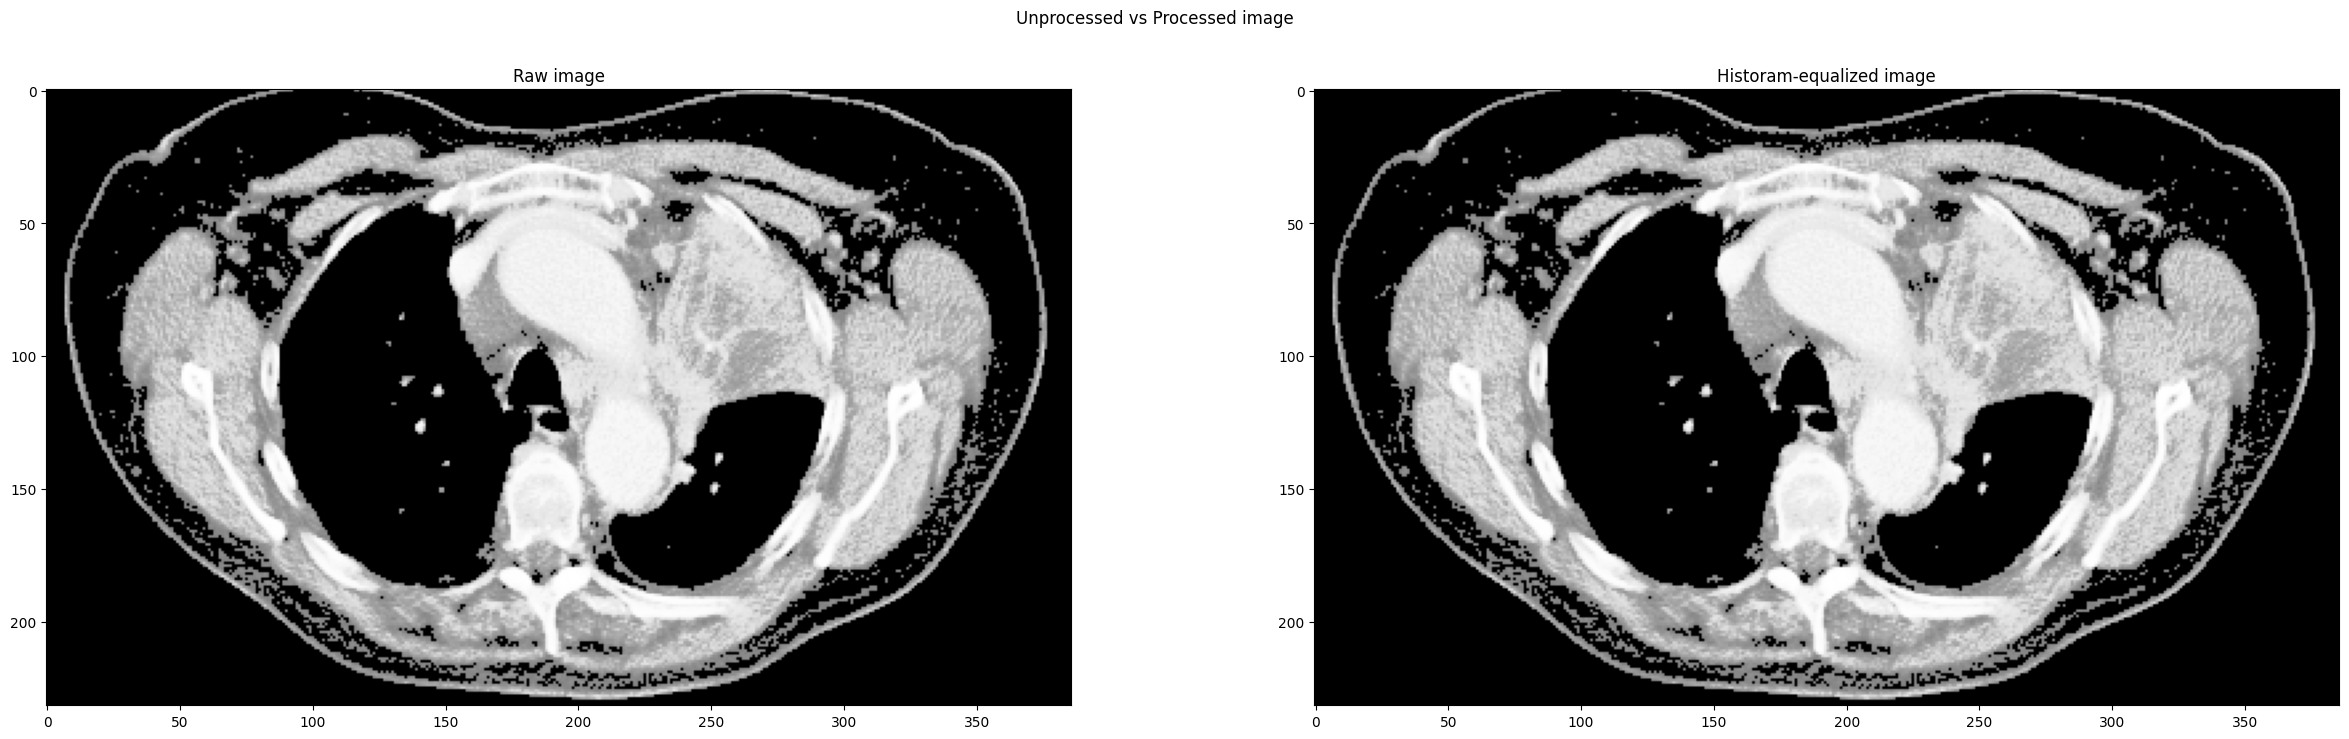

**Splitting the processed images**

In [ ]:
FINAL_DIR = '/content/drive/MyDrive/BIO_Project/processedData'

splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2))

Copying files: 0 files [00:00, ? files/s]


In [ ]:
BATCH_SIZE=32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/BIO_Project/processedData/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

Found 699 images belonging to 2 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/BIO_Project/processedData/val',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 99 images belonging to 2 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/BIO_Project/processedData/test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 202 images belonging to 2 classes.


**Neural nets**

In [ ]:
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
      F1,
]

def plot_history(hist, name):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].plot(hist.history['Accuracy'])
  axs[0].plot(hist.history['val_Accuracy'])
  axs[0].set_title(f'{name} Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['train', 'val', 'F1', 'Recall'], loc='upper left')

  axs[1].plot(hist.history['loss'])
  axs[1].plot(hist.history['val_loss'])
  axs[1].set_title(f'{name} Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['train', 'val'], loc='upper left')

  axs[2].plot(hist.history['Precision'])
  axs[2].plot(hist.history['val_Precision'])
  axs[2].set_title(f'{name} Precision')
  axs[2].set_ylabel('Precision')
  axs[2].set_xlabel('Epoch')
  axs[2].legend(['train', 'val'], loc='upper left')

  plt.show()


**CNN**

In [ ]:
CNN = tf.keras.Sequential()
CNN.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN.add(tf.keras.layers.Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Flatten())
CNN.add(tf.keras.layers.Dense(units=64, activation='relu'))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

CNN.summary()

CNN.compile(optimizer="adam", loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 conv2d_99 (Conv2D)          (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 36)      0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 52, 52, 128)      

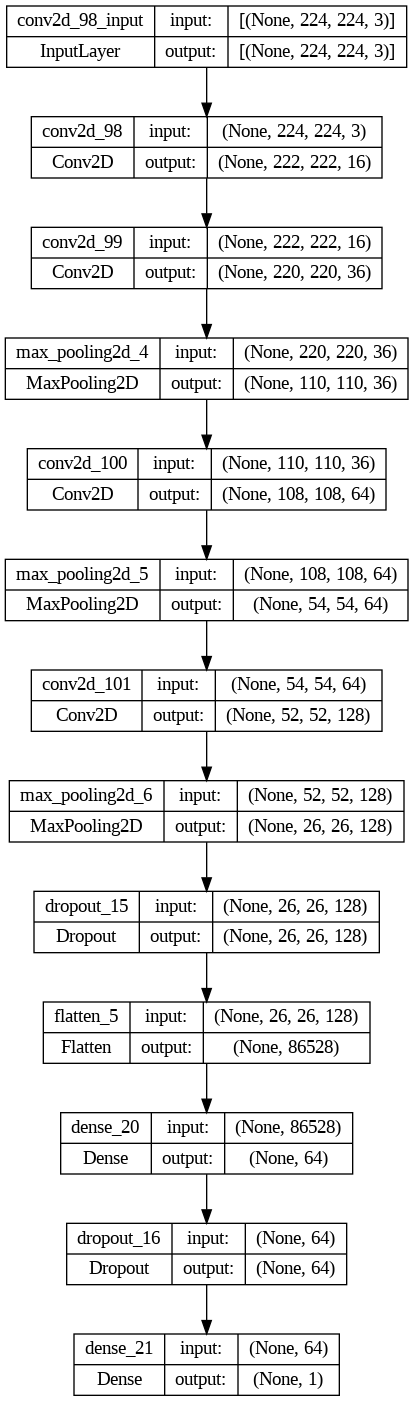

In [ ]:
tf.keras.utils.plot_model(CNN, to_file='CNN.png', show_shapes=True,show_layer_names=True)
Image(filename='CNN.png')

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

# mcp = tf.keras.callbacks.ModelCheckpoint('CNN.h5', save_best_only=True, mode='auto', monitor='val_accuracy')
mcp = tf.keras.callbacks.ModelCheckpoint(
    "CNN.keras", save_best_only=True, mode="auto", monitor="val_accuracy"
)

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

CNN_history = CNN.fit(train_dataset,validation_data=valid_dataset, epochs = 36,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.6481 - Accuracy: 0.8058 - Precision: 0.6377 - Recall: 0.2268 - AUC: 0.6693 - F1: 0.0148

22/22 [==============================] - 23s 690ms/step - loss: 0.6481 - Accuracy: 0.8058 - Precision: 0.6377 - Recall: 0.2268 - AUC: 0.6693 - F1: 0.0148 - val_loss: 0.5413 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.6172 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.4996 - Accuracy: 0.7854 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.6464 - F1: 0.0000e+00

22/22 [==============================] - 13s 574ms/step - loss: 0.4996 - Accuracy: 0.7854 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.6464 - F1: 0.0000e+00 - val_loss: 0.4177 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8382 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4460 - Accuracy: 0.7854 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.7677 - F1: 0.0000e+00

22/22 [==============================] - 14s 626ms/step - loss: 0.4460 - Accuracy: 0.7854 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.7677 - F1: 0.0000e+00 - val_loss: 0.3609 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.9063 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.3916 - Accuracy: 0.8126 - Precision: 0.9130 - Recall: 0.1400 - AUC: 0.8504 - F1: 0.2171

22/22 [==============================] - 13s 581ms/step - loss: 0.3916 - Accuracy: 0.8126 - Precision: 0.9130 - Recall: 0.1400 - AUC: 0.8504 - F1: 0.2171 - val_loss: 0.4914 - val_Accuracy: 0.8081 - val_Precision: 1.0000 - val_Recall: 0.0952 - val_AUC: 0.9237 - val_F1: 0.1806 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.4205 - Accuracy: 0.8183 - Precision: 0.8710 - Recall: 0.1800 - AUC: 0.8154 - F1: 0.2557

22/22 [==============================] - 13s 572ms/step - loss: 0.4205 - Accuracy: 0.8183 - Precision: 0.8710 - Recall: 0.1800 - AUC: 0.8154 - F1: 0.2557 - val_loss: 0.3002 - val_Accuracy: 0.9192 - val_Precision: 1.0000 - val_Recall: 0.6190 - val_AUC: 0.9692 - val_F1: 0.5119 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.3329 - Accuracy: 0.8684 - Precision: 0.9143 - Recall: 0.4267 - AUC: 0.9006 - F1: 0.5272

22/22 [==============================] - 13s 576ms/step - loss: 0.3329 - Accuracy: 0.8684 - Precision: 0.9143 - Recall: 0.4267 - AUC: 0.9006 - F1: 0.5272 - val_loss: 0.5951 - val_Accuracy: 0.5758 - val_Precision: 0.3333 - val_Recall: 1.0000 - val_AUC: 0.9350 - val_F1: 0.4983 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3476 - Accuracy: 0.8512 - Precision: 0.7054 - Recall: 0.5267 - AUC: 0.8781 - F1: 0.5530

22/22 [==============================] - 13s 588ms/step - loss: 0.3476 - Accuracy: 0.8512 - Precision: 0.7054 - Recall: 0.5267 - AUC: 0.8781 - F1: 0.5530 - val_loss: 0.2814 - val_Accuracy: 0.9293 - val_Precision: 0.7692 - val_Recall: 0.9524 - val_AUC: 0.9847 - val_F1: 0.6286 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2997 - Accuracy: 0.8727 - Precision: 0.8144 - Recall: 0.5267 - AUC: 0.9143 - F1: 0.5985

22/22 [==============================] - 12s 564ms/step - loss: 0.2997 - Accuracy: 0.8727 - Precision: 0.8144 - Recall: 0.5267 - AUC: 0.9143 - F1: 0.5985 - val_loss: 0.5507 - val_Accuracy: 0.6566 - val_Precision: 0.3818 - val_Recall: 1.0000 - val_AUC: 0.9673 - val_F1: 0.4260 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2990 - Accuracy: 0.8755 - Precision: 0.7520 - Recall: 0.6267 - AUC: 0.9095 - F1: 0.6344

22/22 [==============================] - 13s 578ms/step - loss: 0.2990 - Accuracy: 0.8755 - Precision: 0.7520 - Recall: 0.6267 - AUC: 0.9095 - F1: 0.6344 - val_loss: 0.2370 - val_Accuracy: 0.9394 - val_Precision: 0.7778 - val_Recall: 1.0000 - val_AUC: 0.9902 - val_F1: 0.8996 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.3132 - Accuracy: 0.8770 - Precision: 0.7500 - Recall: 0.6400 - AUC: 0.9009 - F1: 0.6639

22/22 [==============================] - 12s 548ms/step - loss: 0.3132 - Accuracy: 0.8770 - Precision: 0.7500 - Recall: 0.6400 - AUC: 0.9009 - F1: 0.6639 - val_loss: 0.1839 - val_Accuracy: 0.9394 - val_Precision: 0.8947 - val_Recall: 0.8095 - val_AUC: 0.9908 - val_F1: 0.6254 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.2769 - Accuracy: 0.8856 - Precision: 0.8365 - Recall: 0.5800 - AUC: 0.9285 - F1: 0.6667

22/22 [==============================] - 13s 587ms/step - loss: 0.2769 - Accuracy: 0.8856 - Precision: 0.8365 - Recall: 0.5800 - AUC: 0.9285 - F1: 0.6667 - val_loss: 0.3615 - val_Accuracy: 0.8182 - val_Precision: 0.5385 - val_Recall: 1.0000 - val_AUC: 0.9881 - val_F1: 0.7024 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.2464 - Accuracy: 0.8984 - Precision: 0.8160 - Recall: 0.6800 - AUC: 0.9466 - F1: 0.6984

22/22 [==============================] - 13s 575ms/step - loss: 0.2464 - Accuracy: 0.8984 - Precision: 0.8160 - Recall: 0.6800 - AUC: 0.9466 - F1: 0.6984 - val_loss: 0.2086 - val_Accuracy: 0.9192 - val_Precision: 0.7241 - val_Recall: 1.0000 - val_AUC: 0.9890 - val_F1: 0.6251 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.2759 - Accuracy: 0.8727 - Precision: 0.7480 - Recall: 0.6133 - AUC: 0.9268 - F1: 0.6642
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 13s 573ms/step - loss: 0.2759 - Accuracy: 0.8727 - Precision: 0.7480 - Recall: 0.6133 - AUC: 0.9268 - F1: 0.6642 - val_loss: 0.2013 - val_Accuracy: 0.9192 - val_Precision: 0.7241 - val_Recall: 1.0000 - val_AUC: 0.9890 - val_F1: 0.8752 - lr: 0.0010
Epoch 13: early stopping


In [ ]:
CNN_scores = CNN.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 2s 224ms/step - loss: 0.1729 - Accuracy: 0.9505 - Precision: 0.8400 - Recall: 0.9545 - AUC: 0.9878 - F1: 0.8811


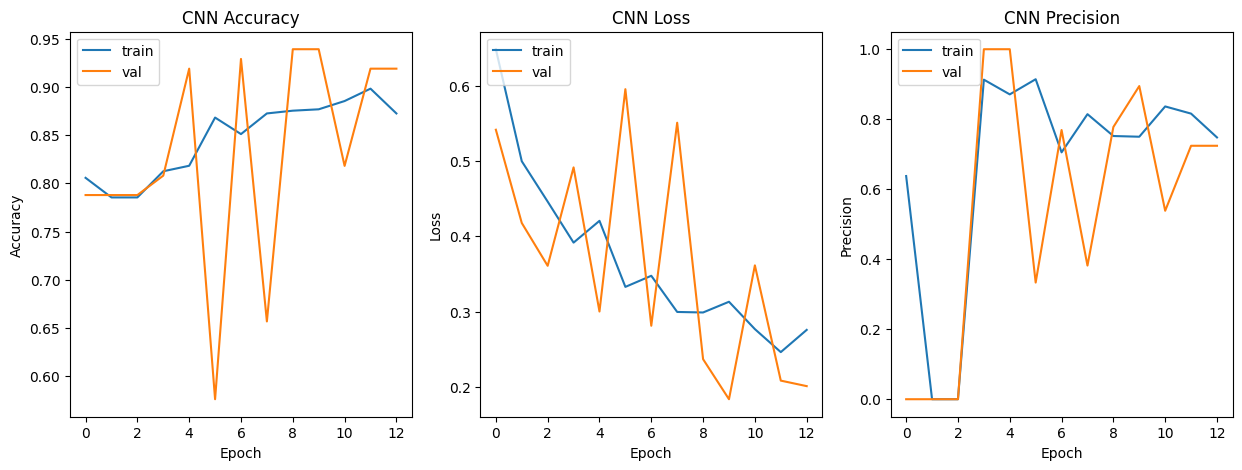

In [ ]:
plot_history(CNN_history, 'CNN')

**VGG16**

In [ ]:
VGG16_base = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)

for layer in VGG16_base.layers:
    layer.trainable = False

VGG16 = tf.keras.Sequential()
VGG16.add(VGG16_base)
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Flatten())
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Dense(32, kernel_initializer="he_uniform"))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation("relu"))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32, kernel_initializer="he_uniform"))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation("relu"))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32, kernel_initializer="he_uniform"))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation("relu"))
VGG16.add(tf.keras.layers.Dense(1, activation="sigmoid"))

VGG16.summary()

VGG16.compile(
    optimizer="rmsprop", loss=tf.keras.losses.binary_crossentropy, metrics=METRICS
)

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_17 (Dropout)        (None, 7, 7, 512)         0         
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_118 (B  (None, 25088)             100352    
 atchNormalization)                                              
                                                                 
 dense_22 (Dense)            (None, 32)                802848    
                                                                 
 batch_normalization_119 (B  (None, 32)                

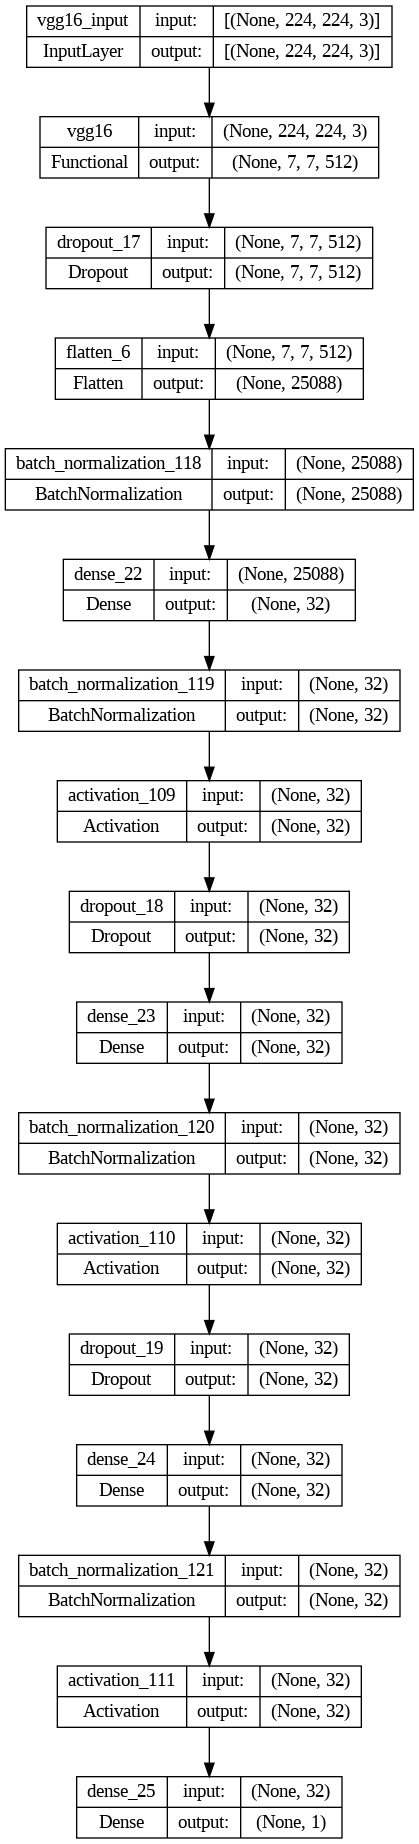

In [ ]:
tf.keras.utils.plot_model(VGG16, to_file='VGG16.png', show_shapes=True,show_layer_names=True)
Image(filename='VGG16.png')

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('VGG16.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

#mcp = tf.keras.callbacks.ModelCheckpoint("VGG16.keras", save_best_only=True, mode="auto", monitor="val_accuracy")

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

VGG16_history = VGG16.fit(train_dataset,validation_data=valid_dataset, epochs = 36, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.6861 - Accuracy: 0.6859 - Precision: 0.3614 - Recall: 0.5979 - AUC: 0.7459 - F1: 0.3615

22/22 [==============================] - 16s 588ms/step - loss: 0.6861 - Accuracy: 0.6859 - Precision: 0.3614 - Recall: 0.5979 - AUC: 0.7459 - F1: 0.3615 - val_loss: 0.5523 - val_Accuracy: 0.7677 - val_Precision: 0.4500 - val_Recall: 0.4286 - val_AUC: 0.7121 - val_F1: 0.3289 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.5168 - Accuracy: 0.8026 - Precision: 0.5337 - Recall: 0.6333 - AUC: 0.8038 - F1: 0.5630

22/22 [==============================] - 14s 628ms/step - loss: 0.5168 - Accuracy: 0.8026 - Precision: 0.5337 - Recall: 0.6333 - AUC: 0.8038 - F1: 0.5630 - val_loss: 0.4249 - val_Accuracy: 0.8384 - val_Precision: 1.0000 - val_Recall: 0.2381 - val_AUC: 0.8993 - val_F1: 0.4489 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4527 - Accuracy: 0.8340 - Precision: 0.6417 - Recall: 0.5133 - AUC: 0.8298 - F1: 0.5502

22/22 [==============================] - 15s 648ms/step - loss: 0.4527 - Accuracy: 0.8340 - Precision: 0.6417 - Recall: 0.5133 - AUC: 0.8298 - F1: 0.5502 - val_loss: 0.3914 - val_Accuracy: 0.9293 - val_Precision: 1.0000 - val_Recall: 0.6667 - val_AUC: 0.8855 - val_F1: 0.8389 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.3961 - Accuracy: 0.8698 - Precision: 0.7706 - Recall: 0.5600 - AUC: 0.8617 - F1: 0.6479

22/22 [==============================] - 13s 578ms/step - loss: 0.3961 - Accuracy: 0.8698 - Precision: 0.7706 - Recall: 0.5600 - AUC: 0.8617 - F1: 0.6479 - val_loss: 0.3306 - val_Accuracy: 0.8586 - val_Precision: 1.0000 - val_Recall: 0.3333 - val_AUC: 0.9768 - val_F1: 0.3318 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3605 - Accuracy: 0.8684 - Precision: 0.7589 - Recall: 0.5667 - AUC: 0.8858 - F1: 0.6371

22/22 [==============================] - 13s 575ms/step - loss: 0.3605 - Accuracy: 0.8684 - Precision: 0.7589 - Recall: 0.5667 - AUC: 0.8858 - F1: 0.6371 - val_loss: 0.2795 - val_Accuracy: 0.8990 - val_Precision: 1.0000 - val_Recall: 0.5238 - val_AUC: 0.9869 - val_F1: 0.5232 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.3150 - Accuracy: 0.8827 - Precision: 0.7881 - Recall: 0.6200 - AUC: 0.9230 - F1: 0.6851

22/22 [==============================] - 13s 585ms/step - loss: 0.3150 - Accuracy: 0.8827 - Precision: 0.7881 - Recall: 0.6200 - AUC: 0.9230 - F1: 0.6851 - val_loss: 0.2390 - val_Accuracy: 0.9293 - val_Precision: 1.0000 - val_Recall: 0.6667 - val_AUC: 0.9786 - val_F1: 0.7808 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3166 - Accuracy: 0.8827 - Precision: 0.7931 - Recall: 0.6133 - AUC: 0.9164 - F1: 0.6606

22/22 [==============================] - 13s 585ms/step - loss: 0.3166 - Accuracy: 0.8827 - Precision: 0.7931 - Recall: 0.6133 - AUC: 0.9164 - F1: 0.6606 - val_loss: 0.1835 - val_Accuracy: 0.9394 - val_Precision: 1.0000 - val_Recall: 0.7143 - val_AUC: 0.9905 - val_F1: 0.6234 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2916 - Accuracy: 0.8784 - Precision: 0.7600 - Recall: 0.6333 - AUC: 0.9304 - F1: 0.6800

22/22 [==============================] - 14s 646ms/step - loss: 0.2916 - Accuracy: 0.8784 - Precision: 0.7600 - Recall: 0.6333 - AUC: 0.9304 - F1: 0.6800 - val_loss: 0.1544 - val_Accuracy: 0.9394 - val_Precision: 1.0000 - val_Recall: 0.7143 - val_AUC: 0.9924 - val_F1: 0.6068 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2606 - Accuracy: 0.8870 - Precision: 0.7795 - Recall: 0.6600 - AUC: 0.9408 - F1: 0.7075

22/22 [==============================] - 13s 590ms/step - loss: 0.2606 - Accuracy: 0.8870 - Precision: 0.7795 - Recall: 0.6600 - AUC: 0.9408 - F1: 0.7075 - val_loss: 0.1326 - val_Accuracy: 0.9697 - val_Precision: 1.0000 - val_Recall: 0.8571 - val_AUC: 0.9930 - val_F1: 0.6083 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.2407 - Accuracy: 0.9099 - Precision: 0.8321 - Recall: 0.7267 - AUC: 0.9577 - F1: 0.7629

22/22 [==============================] - 13s 595ms/step - loss: 0.2407 - Accuracy: 0.9099 - Precision: 0.8321 - Recall: 0.7267 - AUC: 0.9577 - F1: 0.7629 - val_loss: 0.1165 - val_Accuracy: 0.9697 - val_Precision: 1.0000 - val_Recall: 0.8571 - val_AUC: 0.9954 - val_F1: 0.8750 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.2288 - Accuracy: 0.9127 - Precision: 0.8560 - Recall: 0.7133 - AUC: 0.9518 - F1: 0.7957

22/22 [==============================] - 13s 581ms/step - loss: 0.2288 - Accuracy: 0.9127 - Precision: 0.8560 - Recall: 0.7133 - AUC: 0.9518 - F1: 0.7957 - val_loss: 0.1080 - val_Accuracy: 0.9697 - val_Precision: 1.0000 - val_Recall: 0.8571 - val_AUC: 0.9948 - val_F1: 0.6797 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.2076 - Accuracy: 0.9342 - Precision: 0.9062 - Recall: 0.7733 - AUC: 0.9486 - F1: 0.8321

22/22 [==============================] - 13s 587ms/step - loss: 0.2076 - Accuracy: 0.9342 - Precision: 0.9062 - Recall: 0.7733 - AUC: 0.9486 - F1: 0.8321 - val_loss: 0.0980 - val_Accuracy: 0.9798 - val_Precision: 1.0000 - val_Recall: 0.9048 - val_AUC: 0.9945 - val_F1: 0.7500 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.1758 - Accuracy: 0.9413 - Precision: 0.9291 - Recall: 0.7867 - AUC: 0.9775 - F1: 0.8362

22/22 [==============================] - 13s 583ms/step - loss: 0.1758 - Accuracy: 0.9413 - Precision: 0.9291 - Recall: 0.7867 - AUC: 0.9775 - F1: 0.8362 - val_loss: 0.0877 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9954 - val_F1: 0.7500 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.2074 - Accuracy: 0.9199 - Precision: 0.8310 - Recall: 0.7867 - AUC: 0.9575 - F1: 0.7977

22/22 [==============================] - 13s 591ms/step - loss: 0.2074 - Accuracy: 0.9199 - Precision: 0.8310 - Recall: 0.7867 - AUC: 0.9575 - F1: 0.7977 - val_loss: 0.0885 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9911 - val_F1: 0.9808 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.2290 - Accuracy: 0.9084 - Precision: 0.8028 - Recall: 0.7600 - AUC: 0.9572 - F1: 0.7781

22/22 [==============================] - 13s 581ms/step - loss: 0.2290 - Accuracy: 0.9084 - Precision: 0.8028 - Recall: 0.7600 - AUC: 0.9572 - F1: 0.7781 - val_loss: 0.0777 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9954 - val_F1: 0.7273 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.1618 - Accuracy: 0.9342 - Precision: 0.8714 - Recall: 0.8133 - AUC: 0.9807 - F1: 0.8339

22/22 [==============================] - 13s 577ms/step - loss: 0.1618 - Accuracy: 0.9342 - Precision: 0.8714 - Recall: 0.8133 - AUC: 0.9807 - F1: 0.8339 - val_loss: 0.0775 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9890 - val_F1: 0.7273 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.1775 - Accuracy: 0.9299 - Precision: 0.8741 - Recall: 0.7867 - AUC: 0.9742 - F1: 0.8223

22/22 [==============================] - 13s 587ms/step - loss: 0.1775 - Accuracy: 0.9299 - Precision: 0.8741 - Recall: 0.7867 - AUC: 0.9742 - F1: 0.8223 - val_loss: 0.0724 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9875 - val_F1: 0.9773 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.1692 - Accuracy: 0.9256 - Precision: 0.8603 - Recall: 0.7800 - AUC: 0.9754 - F1: 0.8207

22/22 [==============================] - 13s 582ms/step - loss: 0.1692 - Accuracy: 0.9256 - Precision: 0.8603 - Recall: 0.7800 - AUC: 0.9754 - F1: 0.8207 - val_loss: 0.0672 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9893 - val_F1: 0.9833 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.1572 - Accuracy: 0.9456 - Precision: 0.8944 - Recall: 0.8467 - AUC: 0.9777 - F1: 0.8715

22/22 [==============================] - 14s 639ms/step - loss: 0.1572 - Accuracy: 0.9456 - Precision: 0.8944 - Recall: 0.8467 - AUC: 0.9777 - F1: 0.8715 - val_loss: 0.0650 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9908 - val_F1: 0.9853 - lr: 0.0010
Epoch 20/36
22/22 [==============================] - ETA: 0s - loss: 0.1836 - Accuracy: 0.9299 - Precision: 0.8435 - Recall: 0.8267 - AUC: 0.9750 - F1: 0.8279

22/22 [==============================] - 13s 580ms/step - loss: 0.1836 - Accuracy: 0.9299 - Precision: 0.8435 - Recall: 0.8267 - AUC: 0.9750 - F1: 0.8279 - val_loss: 0.0688 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9850 - val_F1: 0.9853 - lr: 0.0010
Epoch 21/36
22/22 [==============================] - ETA: 0s - loss: 0.1562 - Accuracy: 0.9385 - Precision: 0.8794 - Recall: 0.8267 - AUC: 0.9791 - F1: 0.8524

22/22 [==============================] - 13s 613ms/step - loss: 0.1562 - Accuracy: 0.9385 - Precision: 0.8794 - Recall: 0.8267 - AUC: 0.9791 - F1: 0.8524 - val_loss: 0.0685 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9930 - val_F1: 0.9773 - lr: 0.0010
Epoch 22/36
22/22 [==============================] - ETA: 0s - loss: 0.1531 - Accuracy: 0.9371 - Precision: 0.8581 - Recall: 0.8467 - AUC: 0.9784 - F1: 0.8427
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 13s 574ms/step - loss: 0.1531 - Accuracy: 0.9371 - Precision: 0.8581 - Recall: 0.8467 - AUC: 0.9784 - F1: 0.8427 - val_loss: 0.0677 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9783 - val_F1: 0.7333 - lr: 0.0010
Epoch 22: early stopping


In [ ]:
VGG16_scores = VGG16.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 1s 170ms/step - loss: 0.0305 - Accuracy: 0.9950 - Precision: 0.9778 - Recall: 1.0000 - AUC: 1.0000 - F1: 0.9932


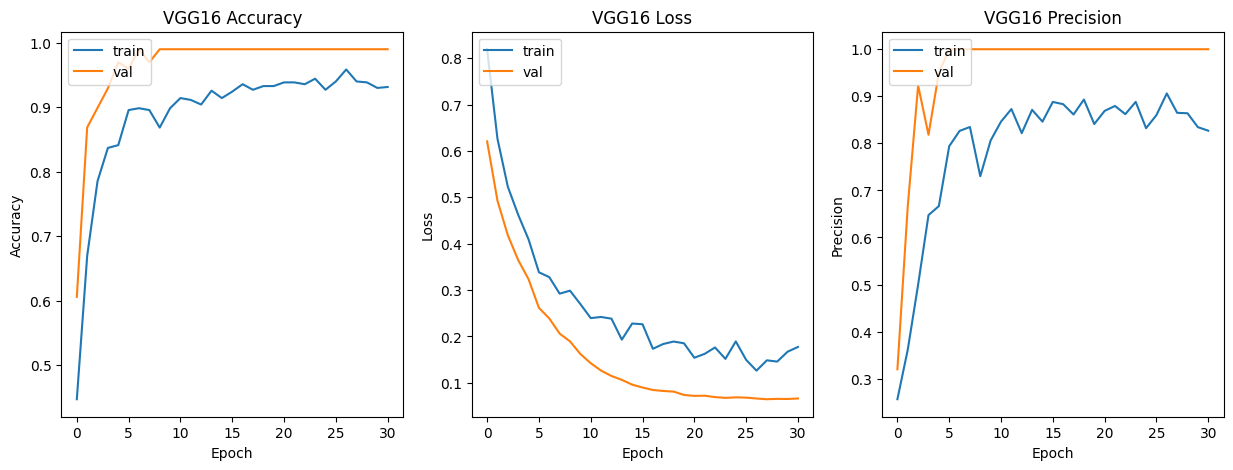

In [ ]:
plot_history(VGG16_history, 'VGG16')

**MobileNet**

In [ ]:
MOBILENET_base =  tf.keras.applications.MobileNet(input_shape=(224,224,3), include_top= False)

for layer in MOBILENET_base.layers:
    layer.trainable = False

MOBILENET=tf.keras.Sequential()
MOBILENET.add(MOBILENET_base)
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Flatten())
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dense(1,activation='sigmoid'))

MOBILENET.summary()

MOBILENET.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization (Batch  (None, 50176)             200704    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                1605664   
                                                         

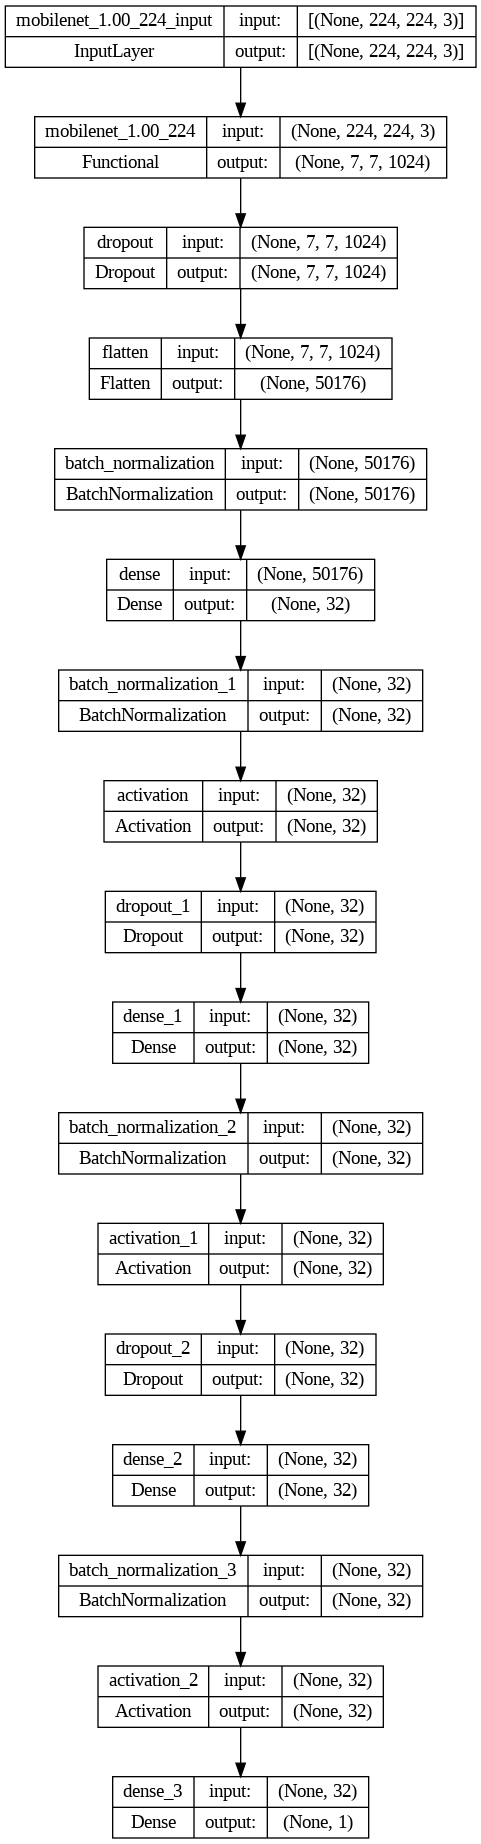

In [ ]:
tf.keras.utils.plot_model(MOBILENET, to_file='MOBILENET.png', show_shapes=True,show_layer_names=True)
Image(filename='MOBILENET.png')

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('MOBILENET.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

MOBILENET_history = MOBILENET.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.7659 - Accuracy: 0.4678 - Precision: 0.2716 - Recall: 0.8800 - AUC: 0.7449 - F1: 0.4091

22/22 [==============================] - 89s 3s/step - loss: 0.7659 - Accuracy: 0.4678 - Precision: 0.2716 - Recall: 0.8800 - AUC: 0.7449 - F1: 0.4091 - val_loss: 0.9161 - val_Accuracy: 0.5758 - val_Precision: 0.3333 - val_Recall: 1.0000 - val_AUC: 0.9869 - val_F1: 0.3835 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.5765 - Accuracy: 0.7468 - Precision: 0.4502 - Recall: 0.8133 - AUC: 0.8567 - F1: 0.5820

22/22 [==============================] - 12s 539ms/step - loss: 0.5765 - Accuracy: 0.7468 - Precision: 0.4502 - Recall: 0.8133 - AUC: 0.8567 - F1: 0.5820 - val_loss: 0.3140 - val_Accuracy: 0.8889 - val_Precision: 0.6562 - val_Recall: 1.0000 - val_AUC: 0.9945 - val_F1: 0.7286 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4833 - Accuracy: 0.8512 - Precision: 0.6307 - Recall: 0.7400 - AUC: 0.8876 - F1: 0.6478

22/22 [==============================] - 12s 514ms/step - loss: 0.4833 - Accuracy: 0.8512 - Precision: 0.6307 - Recall: 0.7400 - AUC: 0.8876 - F1: 0.6478 - val_loss: 0.3155 - val_Accuracy: 0.8889 - val_Precision: 0.6667 - val_Recall: 0.9524 - val_AUC: 0.9872 - val_F1: 0.5900 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.3962 - Accuracy: 0.8941 - Precision: 0.7468 - Recall: 0.7667 - AUC: 0.9232 - F1: 0.7436

22/22 [==============================] - 12s 557ms/step - loss: 0.3962 - Accuracy: 0.8941 - Precision: 0.7468 - Recall: 0.7667 - AUC: 0.9232 - F1: 0.7436 - val_loss: 0.3946 - val_Accuracy: 0.8889 - val_Precision: 0.6667 - val_Recall: 0.9524 - val_AUC: 0.9805 - val_F1: 0.5854 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3129 - Accuracy: 0.9242 - Precision: 0.8089 - Recall: 0.8467 - AUC: 0.9632 - F1: 0.8189

22/22 [==============================] - 12s 556ms/step - loss: 0.3129 - Accuracy: 0.9242 - Precision: 0.8089 - Recall: 0.8467 - AUC: 0.9632 - F1: 0.8189 - val_loss: 0.2738 - val_Accuracy: 0.9394 - val_Precision: 0.8000 - val_Recall: 0.9524 - val_AUC: 0.9869 - val_F1: 0.8936 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.2810 - Accuracy: 0.9285 - Precision: 0.8788 - Recall: 0.7733 - AUC: 0.9504 - F1: 0.8171

22/22 [==============================] - 12s 556ms/step - loss: 0.2810 - Accuracy: 0.9285 - Precision: 0.8788 - Recall: 0.7733 - AUC: 0.9504 - F1: 0.8171 - val_loss: 0.2226 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9835 - val_F1: 0.9750 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.2287 - Accuracy: 0.9385 - Precision: 0.8905 - Recall: 0.8133 - AUC: 0.9740 - F1: 0.8487

22/22 [==============================] - 12s 557ms/step - loss: 0.2287 - Accuracy: 0.9385 - Precision: 0.8905 - Recall: 0.8133 - AUC: 0.9740 - F1: 0.8487 - val_loss: 0.1841 - val_Accuracy: 0.9697 - val_Precision: 0.9091 - val_Recall: 0.9524 - val_AUC: 0.9719 - val_F1: 0.6972 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2233 - Accuracy: 0.9299 - Precision: 0.8976 - Recall: 0.7600 - AUC: 0.9695 - F1: 0.8127

22/22 [==============================] - 12s 559ms/step - loss: 0.2233 - Accuracy: 0.9299 - Precision: 0.8976 - Recall: 0.7600 - AUC: 0.9695 - F1: 0.8127 - val_loss: 0.1490 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9625 - val_F1: 0.7353 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.1919 - Accuracy: 0.9385 - Precision: 0.8905 - Recall: 0.8133 - AUC: 0.9720 - F1: 0.8481

22/22 [==============================] - 12s 547ms/step - loss: 0.1919 - Accuracy: 0.9385 - Precision: 0.8905 - Recall: 0.8133 - AUC: 0.9720 - F1: 0.8481 - val_loss: 0.1158 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9628 - val_F1: 0.9853 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.1721 - Accuracy: 0.9456 - Precision: 0.9118 - Recall: 0.8267 - AUC: 0.9829 - F1: 0.8684

22/22 [==============================] - 12s 545ms/step - loss: 0.1721 - Accuracy: 0.9456 - Precision: 0.9118 - Recall: 0.8267 - AUC: 0.9829 - F1: 0.8684 - val_loss: 0.1002 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9704 - val_F1: 0.9773 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.1909 - Accuracy: 0.9371 - Precision: 0.8897 - Recall: 0.8067 - AUC: 0.9728 - F1: 0.8323

22/22 [==============================] - 12s 559ms/step - loss: 0.1909 - Accuracy: 0.9371 - Precision: 0.8897 - Recall: 0.8067 - AUC: 0.9728 - F1: 0.8323 - val_loss: 0.0956 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9618 - val_F1: 0.9773 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.1481 - Accuracy: 0.9471 - Precision: 0.9449 - Recall: 0.8000 - AUC: 0.9816 - F1: 0.8726

22/22 [==============================] - 12s 551ms/step - loss: 0.1481 - Accuracy: 0.9471 - Precision: 0.9449 - Recall: 0.8000 - AUC: 0.9816 - F1: 0.8726 - val_loss: 0.0880 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9799 - val_F1: 0.7143 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.1461 - Accuracy: 0.9485 - Precision: 0.9071 - Recall: 0.8467 - AUC: 0.9851 - F1: 0.8649

22/22 [==============================] - 12s 554ms/step - loss: 0.1461 - Accuracy: 0.9485 - Precision: 0.9071 - Recall: 0.8467 - AUC: 0.9851 - F1: 0.8649 - val_loss: 0.0793 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9811 - val_F1: 0.9833 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.1320 - Accuracy: 0.9585 - Precision: 0.9007 - Recall: 0.9067 - AUC: 0.9848 - F1: 0.8826

22/22 [==============================] - 12s 552ms/step - loss: 0.1320 - Accuracy: 0.9585 - Precision: 0.9007 - Recall: 0.9067 - AUC: 0.9848 - F1: 0.8826 - val_loss: 0.0692 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9857 - val_F1: 0.9833 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.1340 - Accuracy: 0.9557 - Precision: 0.9220 - Recall: 0.8667 - AUC: 0.9866 - F1: 0.8834

22/22 [==============================] - 12s 560ms/step - loss: 0.1340 - Accuracy: 0.9557 - Precision: 0.9220 - Recall: 0.8667 - AUC: 0.9866 - F1: 0.8834 - val_loss: 0.0670 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9744 - val_F1: 0.7273 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.1451 - Accuracy: 0.9485 - Precision: 0.8851 - Recall: 0.8733 - AUC: 0.9810 - F1: 0.8670

22/22 [==============================] - 12s 562ms/step - loss: 0.1451 - Accuracy: 0.9485 - Precision: 0.8851 - Recall: 0.8733 - AUC: 0.9810 - F1: 0.8670 - val_loss: 0.0686 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9741 - val_F1: 0.7353 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.1050 - Accuracy: 0.9599 - Precision: 0.9420 - Recall: 0.8667 - AUC: 0.9932 - F1: 0.8996

22/22 [==============================] - 12s 549ms/step - loss: 0.1050 - Accuracy: 0.9599 - Precision: 0.9420 - Recall: 0.8667 - AUC: 0.9932 - F1: 0.8996 - val_loss: 0.0650 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9838 - val_F1: 0.7308 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.0979 - Accuracy: 0.9614 - Precision: 0.9184 - Recall: 0.9000 - AUC: 0.9930 - F1: 0.9060

22/22 [==============================] - 12s 530ms/step - loss: 0.0979 - Accuracy: 0.9614 - Precision: 0.9184 - Recall: 0.9000 - AUC: 0.9930 - F1: 0.9060 - val_loss: 0.0622 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9716 - val_F1: 0.7381 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.0739 - Accuracy: 0.9742 - Precision: 0.9583 - Recall: 0.9200 - AUC: 0.9956 - F1: 0.9429

22/22 [==============================] - 12s 548ms/step - loss: 0.0739 - Accuracy: 0.9742 - Precision: 0.9583 - Recall: 0.9200 - AUC: 0.9956 - F1: 0.9429 - val_loss: 0.0608 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9802 - val_F1: 0.9808 - lr: 0.0010
Epoch 20/36
22/22 [==============================] - ETA: 0s - loss: 0.1401 - Accuracy: 0.9585 - Precision: 0.9007 - Recall: 0.9067 - AUC: 0.9844 - F1: 0.8841

22/22 [==============================] - 12s 554ms/step - loss: 0.1401 - Accuracy: 0.9585 - Precision: 0.9007 - Recall: 0.9067 - AUC: 0.9844 - F1: 0.8841 - val_loss: 0.0681 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9673 - val_F1: 0.9583 - lr: 0.0010
Epoch 21/36
22/22 [==============================] - ETA: 0s - loss: 0.0946 - Accuracy: 0.9671 - Precision: 0.9320 - Recall: 0.9133 - AUC: 0.9929 - F1: 0.9243

22/22 [==============================] - 12s 553ms/step - loss: 0.0946 - Accuracy: 0.9671 - Precision: 0.9320 - Recall: 0.9133 - AUC: 0.9929 - F1: 0.9243 - val_loss: 0.0683 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9704 - val_F1: 0.9575 - lr: 0.0010
Epoch 22/36
22/22 [==============================] - ETA: 0s - loss: 0.1197 - Accuracy: 0.9499 - Precision: 0.8662 - Recall: 0.9067 - AUC: 0.9886 - F1: 0.8619
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 12s 565ms/step - loss: 0.1197 - Accuracy: 0.9499 - Precision: 0.8662 - Recall: 0.9067 - AUC: 0.9886 - F1: 0.8619 - val_loss: 0.0774 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9725 - val_F1: 0.9687 - lr: 0.0010
Epoch 22: early stopping


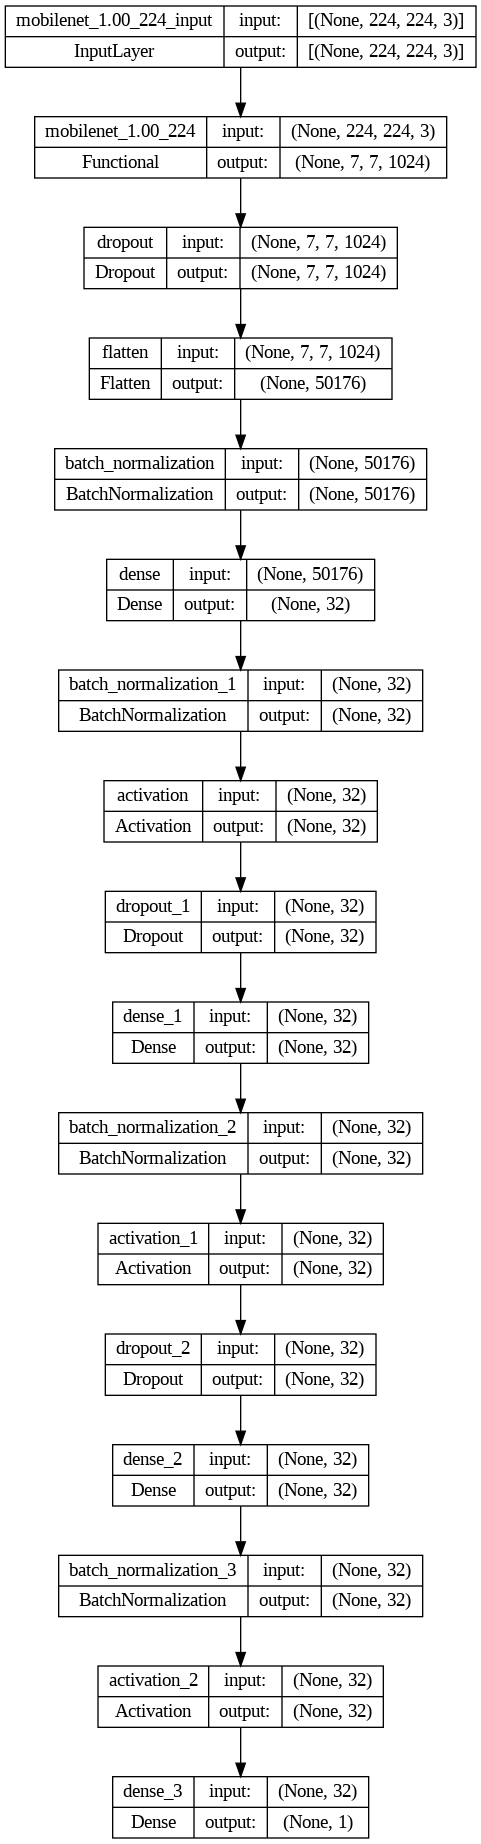

In [ ]:
tf.keras.utils.plot_model(MOBILENET, to_file='MOBILENET.png', show_shapes=True,show_layer_names=True)
Image(filename='MOBILENET.png')

In [ ]:
MOBILENET_scores = MOBILENET.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 46s 8s/step - loss: 0.0209 - Accuracy: 0.9901 - Precision: 0.9773 - Recall: 0.9773 - AUC: 0.9999 - F1: 0.9701


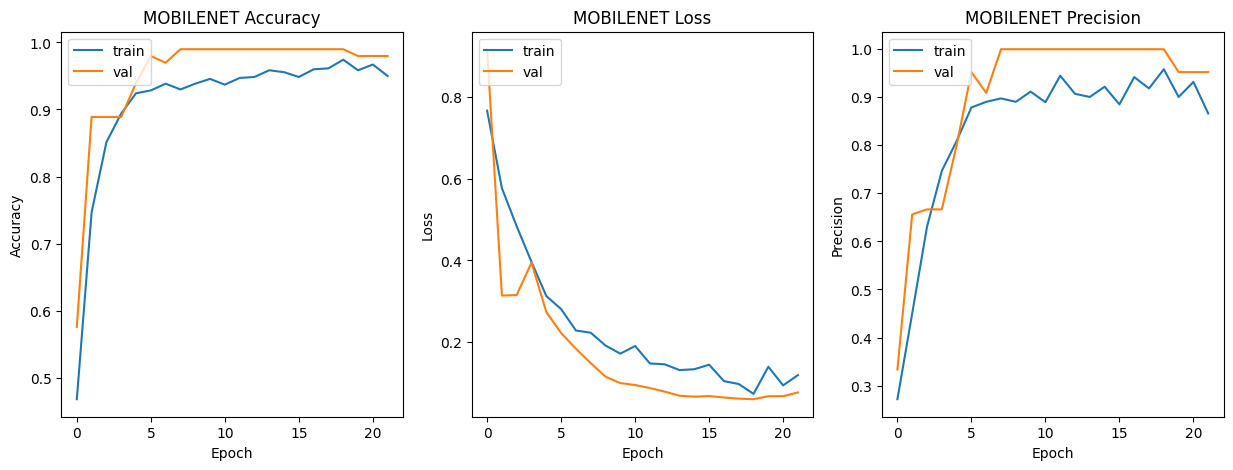

In [ ]:
plot_history(MOBILENET_history, 'MOBILENET')

**VGG19**

In [ ]:
VGG19_base = tf.keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in VGG19_base.layers:
    layer.trainable = False

VGG19=tf.keras.Sequential()
VGG19.add(VGG19_base)
VGG19.add(tf.keras.layers.Dropout(0.5))
VGG19.add(tf.keras.layers.Flatten())
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Activation('relu'))
VGG19.add(tf.keras.layers.Dropout(0.5))
VGG19.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Activation('relu'))
VGG19.add(tf.keras.layers.Dropout(0.5))
VGG19.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Activation('relu'))
VGG19.add(tf.keras.layers.Dense(1,activation='sigmoid'))

VGG19.summary()

VGG19.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_4 (Bat  (None, 25088)             100352    
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 32)                802848    
                                                                 
 batch_normalization_5 (Bat  (None, 32)                

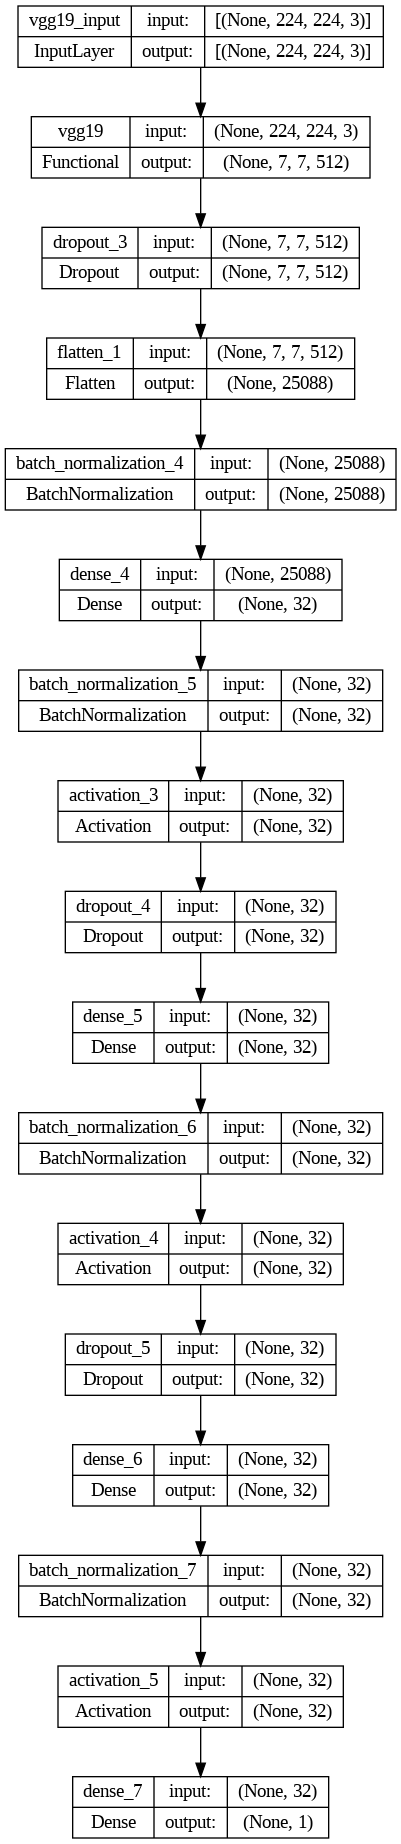

In [ ]:
tf.keras.utils.plot_model(VGG19, to_file='./VGG19.png', show_shapes=True,show_layer_names=True)
Image(filename='VGG19.png')

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('VGG19.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

VGG19_history = VGG19.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.8928 - Accuracy: 0.5549 - Precision: 0.3058 - Recall: 0.8402 - AUC: 0.7827 - F1: 0.3704

22/22 [==============================] - 28s 871ms/step - loss: 0.8928 - Accuracy: 0.5549 - Precision: 0.3058 - Recall: 0.8402 - AUC: 0.7827 - F1: 0.3704 - val_loss: 0.8438 - val_Accuracy: 0.3535 - val_Precision: 0.2471 - val_Recall: 1.0000 - val_AUC: 0.8767 - val_F1: 0.4073 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.6668 - Accuracy: 0.6252 - Precision: 0.3453 - Recall: 0.8333 - AUC: 0.7952 - F1: 0.4808

22/22 [==============================] - 13s 597ms/step - loss: 0.6668 - Accuracy: 0.6252 - Precision: 0.3453 - Recall: 0.8333 - AUC: 0.7952 - F1: 0.4808 - val_loss: 0.4823 - val_Accuracy: 0.9495 - val_Precision: 0.8636 - val_Recall: 0.9048 - val_AUC: 0.9777 - val_F1: 0.9079 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.5403 - Accuracy: 0.7825 - Precision: 0.4957 - Recall: 0.7600 - AUC: 0.8436 - F1: 0.5812

22/22 [==============================] - 13s 598ms/step - loss: 0.5403 - Accuracy: 0.7825 - Precision: 0.4957 - Recall: 0.7600 - AUC: 0.8436 - F1: 0.5812 - val_loss: 0.3885 - val_Accuracy: 0.9596 - val_Precision: 1.0000 - val_Recall: 0.8095 - val_AUC: 0.9899 - val_F1: 0.6343 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4545 - Accuracy: 0.8269 - Precision: 0.5890 - Recall: 0.6400 - AUC: 0.8412 - F1: 0.5988

22/22 [==============================] - 13s 583ms/step - loss: 0.4545 - Accuracy: 0.8269 - Precision: 0.5890 - Recall: 0.6400 - AUC: 0.8412 - F1: 0.5988 - val_loss: 0.3318 - val_Accuracy: 0.9293 - val_Precision: 1.0000 - val_Recall: 0.6667 - val_AUC: 0.9792 - val_F1: 0.8229 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.4096 - Accuracy: 0.8455 - Precision: 0.6479 - Recall: 0.6133 - AUC: 0.8728 - F1: 0.6270

22/22 [==============================] - 13s 590ms/step - loss: 0.4096 - Accuracy: 0.8455 - Precision: 0.6479 - Recall: 0.6133 - AUC: 0.8728 - F1: 0.6270 - val_loss: 0.2526 - val_Accuracy: 0.9495 - val_Precision: 1.0000 - val_Recall: 0.7619 - val_AUC: 0.9857 - val_F1: 0.8603 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.3509 - Accuracy: 0.8841 - Precision: 0.8053 - Recall: 0.6067 - AUC: 0.9062 - F1: 0.6886

22/22 [==============================] - 13s 601ms/step - loss: 0.3509 - Accuracy: 0.8841 - Precision: 0.8053 - Recall: 0.6067 - AUC: 0.9062 - F1: 0.6886 - val_loss: 0.2083 - val_Accuracy: 0.9697 - val_Precision: 1.0000 - val_Recall: 0.8571 - val_AUC: 0.9915 - val_F1: 0.7023 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3359 - Accuracy: 0.8670 - Precision: 0.7522 - Recall: 0.5667 - AUC: 0.9108 - F1: 0.6369

22/22 [==============================] - 13s 600ms/step - loss: 0.3359 - Accuracy: 0.8670 - Precision: 0.7522 - Recall: 0.5667 - AUC: 0.9108 - F1: 0.6369 - val_loss: 0.1599 - val_Accuracy: 0.9697 - val_Precision: 1.0000 - val_Recall: 0.8571 - val_AUC: 0.9969 - val_F1: 0.6883 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2916 - Accuracy: 0.8941 - Precision: 0.8065 - Recall: 0.6667 - AUC: 0.9291 - F1: 0.7198

22/22 [==============================] - 13s 595ms/step - loss: 0.2916 - Accuracy: 0.8941 - Precision: 0.8065 - Recall: 0.6667 - AUC: 0.9291 - F1: 0.7198 - val_loss: 0.1588 - val_Accuracy: 0.9798 - val_Precision: 1.0000 - val_Recall: 0.9048 - val_AUC: 0.9942 - val_F1: 0.9661 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2864 - Accuracy: 0.8784 - Precision: 0.7642 - Recall: 0.6267 - AUC: 0.9294 - F1: 0.6764

22/22 [==============================] - 13s 603ms/step - loss: 0.2864 - Accuracy: 0.8784 - Precision: 0.7642 - Recall: 0.6267 - AUC: 0.9294 - F1: 0.6764 - val_loss: 0.1317 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9899 - val_F1: 0.7333 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.2831 - Accuracy: 0.8970 - Precision: 0.8305 - Recall: 0.6533 - AUC: 0.9183 - F1: 0.7289

22/22 [==============================] - 13s 607ms/step - loss: 0.2831 - Accuracy: 0.8970 - Precision: 0.8305 - Recall: 0.6533 - AUC: 0.9183 - F1: 0.7289 - val_loss: 0.1270 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9832 - val_F1: 0.7308 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.2457 - Accuracy: 0.9099 - Precision: 0.8718 - Recall: 0.6800 - AUC: 0.9497 - F1: 0.7694

22/22 [==============================] - 13s 590ms/step - loss: 0.2457 - Accuracy: 0.9099 - Precision: 0.8718 - Recall: 0.6800 - AUC: 0.9497 - F1: 0.7694 - val_loss: 0.1133 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9869 - val_F1: 0.9868 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.2453 - Accuracy: 0.9013 - Precision: 0.8347 - Recall: 0.6733 - AUC: 0.9451 - F1: 0.7418

22/22 [==============================] - 13s 594ms/step - loss: 0.2453 - Accuracy: 0.9013 - Precision: 0.8347 - Recall: 0.6733 - AUC: 0.9451 - F1: 0.7418 - val_loss: 0.1082 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9838 - val_F1: 0.7273 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.2296 - Accuracy: 0.9070 - Precision: 0.8295 - Recall: 0.7133 - AUC: 0.9524 - F1: 0.7622

22/22 [==============================] - 13s 602ms/step - loss: 0.2296 - Accuracy: 0.9070 - Precision: 0.8295 - Recall: 0.7133 - AUC: 0.9524 - F1: 0.7622 - val_loss: 0.1059 - val_Accuracy: 0.9798 - val_Precision: 1.0000 - val_Recall: 0.9048 - val_AUC: 0.9860 - val_F1: 0.9606 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.1995 - Accuracy: 0.9299 - Precision: 0.8976 - Recall: 0.7600 - AUC: 0.9680 - F1: 0.8226

22/22 [==============================] - 13s 600ms/step - loss: 0.1995 - Accuracy: 0.9299 - Precision: 0.8976 - Recall: 0.7600 - AUC: 0.9680 - F1: 0.8226 - val_loss: 0.0911 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9936 - val_F1: 0.9167 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.2409 - Accuracy: 0.9099 - Precision: 0.8321 - Recall: 0.7267 - AUC: 0.9385 - F1: 0.7733

22/22 [==============================] - 13s 597ms/step - loss: 0.2409 - Accuracy: 0.9099 - Precision: 0.8321 - Recall: 0.7267 - AUC: 0.9385 - F1: 0.7733 - val_loss: 0.0786 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9939 - val_F1: 0.7333 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.1898 - Accuracy: 0.9270 - Precision: 0.8960 - Recall: 0.7467 - AUC: 0.9671 - F1: 0.8131

22/22 [==============================] - 13s 602ms/step - loss: 0.1898 - Accuracy: 0.9270 - Precision: 0.8960 - Recall: 0.7467 - AUC: 0.9671 - F1: 0.8131 - val_loss: 0.0726 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9921 - val_F1: 0.9868 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.2102 - Accuracy: 0.9185 - Precision: 0.8720 - Recall: 0.7267 - AUC: 0.9589 - F1: 0.7847

22/22 [==============================] - 14s 603ms/step - loss: 0.2102 - Accuracy: 0.9185 - Precision: 0.8720 - Recall: 0.7267 - AUC: 0.9589 - F1: 0.7847 - val_loss: 0.0962 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9884 - val_F1: 0.7176 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.2082 - Accuracy: 0.9313 - Precision: 0.8864 - Recall: 0.7800 - AUC: 0.9481 - F1: 0.8148

22/22 [==============================] - 13s 584ms/step - loss: 0.2082 - Accuracy: 0.9313 - Precision: 0.8864 - Recall: 0.7800 - AUC: 0.9481 - F1: 0.8148 - val_loss: 0.0726 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9902 - val_F1: 0.7353 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.1841 - Accuracy: 0.9371 - Precision: 0.8841 - Recall: 0.8133 - AUC: 0.9595 - F1: 0.8490
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 13s 576ms/step - loss: 0.1841 - Accuracy: 0.9371 - Precision: 0.8841 - Recall: 0.8133 - AUC: 0.9595 - F1: 0.8490 - val_loss: 0.0753 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9860 - val_F1: 0.7368 - lr: 0.0010
Epoch 19: early stopping


In [ ]:
VGG19_scores = VGG19.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 4s 583ms/step - loss: 0.0648 - Accuracy: 0.9802 - Precision: 0.9762 - Recall: 0.9318 - AUC: 0.9958 - F1: 0.9546


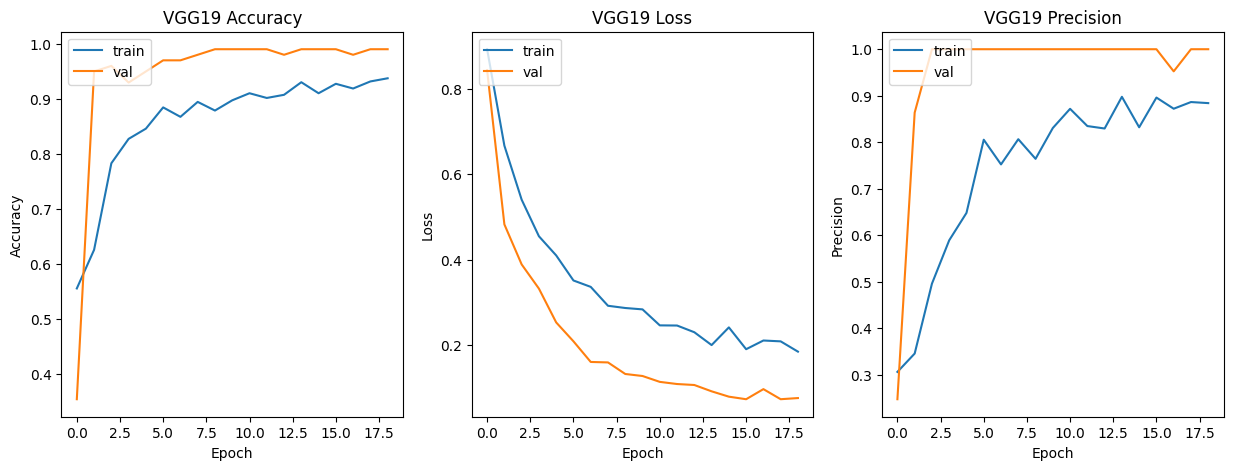

In [ ]:
plot_history(VGG19_history, 'VGG19')

**Xception**

In [ ]:
Xception_base = tf.keras.applications.Xception(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in Xception_base.layers:
    layer.trainable = False

Xception=tf.keras.Sequential()
Xception.add(Xception_base)
Xception.add(tf.keras.layers.Dropout(0.5))
Xception.add(tf.keras.layers.Flatten())
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Activation('relu'))
Xception.add(tf.keras.layers.Dropout(0.5))
Xception.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Activation('relu'))
Xception.add(tf.keras.layers.Dropout(0.5))
Xception.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Activation('relu'))
Xception.add(tf.keras.layers.Dense(1,activation='sigmoid'))

Xception.summary()

Xception.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_12 (Ba  (None, 100352)            401408    
 tchNormalization)                                               
                                                                 
 dense_8 (Dense)             (None, 32)                3211296   
                                                                 
 batch_normalization_13 (Ba  (None, 32)                

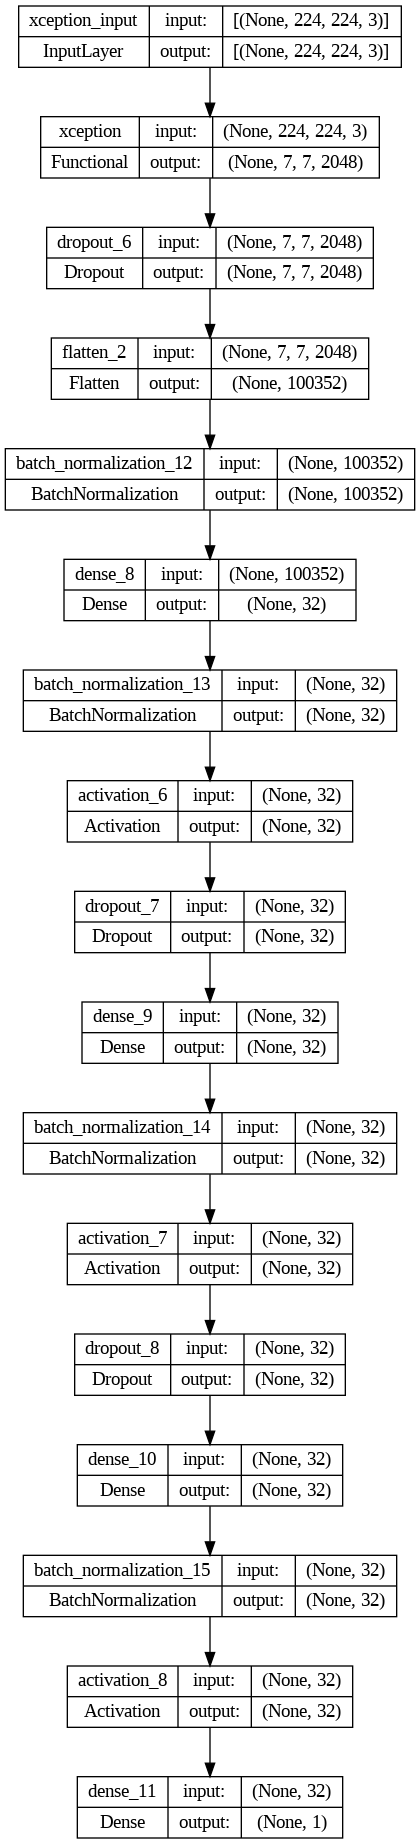

In [ ]:
tf.keras.utils.plot_model(Xception, to_file='./Xception.png', show_shapes=True,show_layer_names=True)
Image(filename='Xception.png')

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('Xception.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

Xception_history = Xception.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.6155 - Accuracy: 0.7569 - Precision: 0.4555 - Recall: 0.6598 - AUC: 0.7997 - F1: 0.4410

22/22 [==============================] - 23s 809ms/step - loss: 0.6155 - Accuracy: 0.7569 - Precision: 0.4555 - Recall: 0.6598 - AUC: 0.7997 - F1: 0.4410 - val_loss: 0.2747 - val_Accuracy: 0.8990 - val_Precision: 0.8235 - val_Recall: 0.6667 - val_AUC: 0.9460 - val_F1: 0.5485 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.4723 - Accuracy: 0.8355 - Precision: 0.6277 - Recall: 0.5733 - AUC: 0.8064 - F1: 0.5876

22/22 [==============================] - 13s 577ms/step - loss: 0.4723 - Accuracy: 0.8355 - Precision: 0.6277 - Recall: 0.5733 - AUC: 0.8064 - F1: 0.5876 - val_loss: 0.2805 - val_Accuracy: 0.9394 - val_Precision: 0.8571 - val_Recall: 0.8571 - val_AUC: 0.9780 - val_F1: 0.6479 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4075 - Accuracy: 0.8584 - Precision: 0.7217 - Recall: 0.5533 - AUC: 0.8564 - F1: 0.6274

22/22 [==============================] - 13s 599ms/step - loss: 0.4075 - Accuracy: 0.8584 - Precision: 0.7217 - Recall: 0.5533 - AUC: 0.8564 - F1: 0.6274 - val_loss: 0.2499 - val_Accuracy: 0.9293 - val_Precision: 0.7692 - val_Recall: 0.9524 - val_AUC: 0.9884 - val_F1: 0.6483 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.3747 - Accuracy: 0.8584 - Precision: 0.7217 - Recall: 0.5533 - AUC: 0.8713 - F1: 0.6179

22/22 [==============================] - 13s 575ms/step - loss: 0.3747 - Accuracy: 0.8584 - Precision: 0.7217 - Recall: 0.5533 - AUC: 0.8713 - F1: 0.6179 - val_loss: 0.1892 - val_Accuracy: 0.9495 - val_Precision: 0.8333 - val_Recall: 0.9524 - val_AUC: 0.9927 - val_F1: 0.9103 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.2800 - Accuracy: 0.9185 - Precision: 0.8974 - Recall: 0.7000 - AUC: 0.9402 - F1: 0.7906

22/22 [==============================] - 13s 585ms/step - loss: 0.2800 - Accuracy: 0.9185 - Precision: 0.8974 - Recall: 0.7000 - AUC: 0.9402 - F1: 0.7906 - val_loss: 0.1933 - val_Accuracy: 0.9495 - val_Precision: 0.8333 - val_Recall: 0.9524 - val_AUC: 0.9945 - val_F1: 0.8230 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.2878 - Accuracy: 0.8984 - Precision: 0.8160 - Recall: 0.6800 - AUC: 0.9319 - F1: 0.7229

22/22 [==============================] - 13s 583ms/step - loss: 0.2878 - Accuracy: 0.8984 - Precision: 0.8160 - Recall: 0.6800 - AUC: 0.9319 - F1: 0.7229 - val_loss: 0.1706 - val_Accuracy: 0.9596 - val_Precision: 0.8696 - val_Recall: 0.9524 - val_AUC: 0.9939 - val_F1: 0.6829 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.2699 - Accuracy: 0.8927 - Precision: 0.8205 - Recall: 0.6400 - AUC: 0.9367 - F1: 0.7092

22/22 [==============================] - 13s 598ms/step - loss: 0.2699 - Accuracy: 0.8927 - Precision: 0.8205 - Recall: 0.6400 - AUC: 0.9367 - F1: 0.7092 - val_loss: 0.1726 - val_Accuracy: 0.9495 - val_Precision: 0.8333 - val_Recall: 0.9524 - val_AUC: 0.9969 - val_F1: 0.9083 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2256 - Accuracy: 0.9170 - Precision: 0.8898 - Recall: 0.7000 - AUC: 0.9545 - F1: 0.7726

22/22 [==============================] - 13s 582ms/step - loss: 0.2256 - Accuracy: 0.9170 - Precision: 0.8898 - Recall: 0.7000 - AUC: 0.9545 - F1: 0.7726 - val_loss: 0.1450 - val_Accuracy: 0.9596 - val_Precision: 0.8696 - val_Recall: 0.9524 - val_AUC: 0.9957 - val_F1: 0.9224 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2462 - Accuracy: 0.9070 - Precision: 0.8455 - Recall: 0.6933 - AUC: 0.9430 - F1: 0.7637

22/22 [==============================] - 13s 581ms/step - loss: 0.2462 - Accuracy: 0.9070 - Precision: 0.8455 - Recall: 0.6933 - AUC: 0.9430 - F1: 0.7637 - val_loss: 0.1448 - val_Accuracy: 0.9394 - val_Precision: 0.8000 - val_Recall: 0.9524 - val_AUC: 0.9957 - val_F1: 0.8973 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.1770 - Accuracy: 0.9356 - Precision: 0.9268 - Recall: 0.7600 - AUC: 0.9768 - F1: 0.8317

22/22 [==============================] - 13s 580ms/step - loss: 0.1770 - Accuracy: 0.9356 - Precision: 0.9268 - Recall: 0.7600 - AUC: 0.9768 - F1: 0.8317 - val_loss: 0.1361 - val_Accuracy: 0.9394 - val_Precision: 0.8000 - val_Recall: 0.9524 - val_AUC: 0.9957 - val_F1: 0.6660 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.1779 - Accuracy: 0.9385 - Precision: 0.8905 - Recall: 0.8133 - AUC: 0.9733 - F1: 0.8350

22/22 [==============================] - 13s 582ms/step - loss: 0.1779 - Accuracy: 0.9385 - Precision: 0.8905 - Recall: 0.8133 - AUC: 0.9733 - F1: 0.8350 - val_loss: 0.1237 - val_Accuracy: 0.9596 - val_Precision: 0.8696 - val_Recall: 0.9524 - val_AUC: 0.9957 - val_F1: 0.6737 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.1591 - Accuracy: 0.9342 - Precision: 0.9000 - Recall: 0.7800 - AUC: 0.9819 - F1: 0.8282

22/22 [==============================] - 13s 580ms/step - loss: 0.1591 - Accuracy: 0.9342 - Precision: 0.9000 - Recall: 0.7800 - AUC: 0.9819 - F1: 0.8282 - val_loss: 0.0897 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9963 - val_F1: 0.9606 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.1889 - Accuracy: 0.9371 - Precision: 0.9015 - Recall: 0.7933 - AUC: 0.9679 - F1: 0.8425

22/22 [==============================] - 13s 577ms/step - loss: 0.1889 - Accuracy: 0.9371 - Precision: 0.9015 - Recall: 0.7933 - AUC: 0.9679 - F1: 0.8425 - val_loss: 0.1046 - val_Accuracy: 0.9697 - val_Precision: 0.9091 - val_Recall: 0.9524 - val_AUC: 0.9921 - val_F1: 0.7105 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.1472 - Accuracy: 0.9442 - Precision: 0.9237 - Recall: 0.8067 - AUC: 0.9792 - F1: 0.8581

22/22 [==============================] - 14s 638ms/step - loss: 0.1472 - Accuracy: 0.9442 - Precision: 0.9237 - Recall: 0.8067 - AUC: 0.9792 - F1: 0.8581 - val_loss: 0.0950 - val_Accuracy: 0.9596 - val_Precision: 0.8696 - val_Recall: 0.9524 - val_AUC: 0.9921 - val_F1: 0.6833 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.1668 - Accuracy: 0.9313 - Precision: 0.8806 - Recall: 0.7867 - AUC: 0.9726 - F1: 0.8231

22/22 [==============================] - 13s 589ms/step - loss: 0.1668 - Accuracy: 0.9313 - Precision: 0.8806 - Recall: 0.7867 - AUC: 0.9726 - F1: 0.8231 - val_loss: 0.0848 - val_Accuracy: 0.9697 - val_Precision: 0.9091 - val_Recall: 0.9524 - val_AUC: 0.9942 - val_F1: 0.9496 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.1932 - Accuracy: 0.9313 - Precision: 0.8806 - Recall: 0.7867 - AUC: 0.9657 - F1: 0.8196

22/22 [==============================] - 13s 584ms/step - loss: 0.1932 - Accuracy: 0.9313 - Precision: 0.8806 - Recall: 0.7867 - AUC: 0.9657 - F1: 0.8196 - val_loss: 0.0802 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9933 - val_F1: 0.9664 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.1533 - Accuracy: 0.9499 - Precision: 0.8912 - Recall: 0.8733 - AUC: 0.9811 - F1: 0.8697

22/22 [==============================] - 13s 582ms/step - loss: 0.1533 - Accuracy: 0.9499 - Precision: 0.8912 - Recall: 0.8733 - AUC: 0.9811 - F1: 0.8697 - val_loss: 0.0809 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9951 - val_F1: 0.7164 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.1485 - Accuracy: 0.9456 - Precision: 0.8836 - Recall: 0.8600 - AUC: 0.9807 - F1: 0.8659

22/22 [==============================] - 13s 587ms/step - loss: 0.1485 - Accuracy: 0.9456 - Precision: 0.8836 - Recall: 0.8600 - AUC: 0.9807 - F1: 0.8659 - val_loss: 0.0694 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9973 - val_F1: 0.9641 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.1519 - Accuracy: 0.9528 - Precision: 0.9270 - Recall: 0.8467 - AUC: 0.9641 - F1: 0.9001

22/22 [==============================] - 13s 572ms/step - loss: 0.1519 - Accuracy: 0.9528 - Precision: 0.9270 - Recall: 0.8467 - AUC: 0.9641 - F1: 0.9001 - val_loss: 0.0842 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9951 - val_F1: 0.7176 - lr: 0.0010
Epoch 20/36
22/22 [==============================] - ETA: 0s - loss: 0.1401 - Accuracy: 0.9485 - Precision: 0.9071 - Recall: 0.8467 - AUC: 0.9783 - F1: 0.8726

22/22 [==============================] - 13s 580ms/step - loss: 0.1401 - Accuracy: 0.9485 - Precision: 0.9071 - Recall: 0.8467 - AUC: 0.9783 - F1: 0.8726 - val_loss: 0.0711 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9942 - val_F1: 0.7154 - lr: 0.0010
Epoch 21/36
22/22 [==============================] - ETA: 0s - loss: 0.1074 - Accuracy: 0.9542 - Precision: 0.9214 - Recall: 0.8600 - AUC: 0.9920 - F1: 0.8882

22/22 [==============================] - 13s 582ms/step - loss: 0.1074 - Accuracy: 0.9542 - Precision: 0.9214 - Recall: 0.8600 - AUC: 0.9920 - F1: 0.8882 - val_loss: 0.0668 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9942 - val_F1: 0.7011 - lr: 0.0010
Epoch 22/36
22/22 [==============================] - ETA: 0s - loss: 0.1325 - Accuracy: 0.9485 - Precision: 0.8800 - Recall: 0.8800 - AUC: 0.9858 - F1: 0.8700

22/22 [==============================] - 13s 586ms/step - loss: 0.1325 - Accuracy: 0.9485 - Precision: 0.8800 - Recall: 0.8800 - AUC: 0.9858 - F1: 0.8700 - val_loss: 0.0667 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9954 - val_F1: 0.9495 - lr: 0.0010
Epoch 23/36
22/22 [==============================] - ETA: 0s - loss: 0.1466 - Accuracy: 0.9471 - Precision: 0.9007 - Recall: 0.8467 - AUC: 0.9825 - F1: 0.8610

22/22 [==============================] - 13s 581ms/step - loss: 0.1466 - Accuracy: 0.9471 - Precision: 0.9007 - Recall: 0.8467 - AUC: 0.9825 - F1: 0.8610 - val_loss: 0.0598 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9966 - val_F1: 0.7161 - lr: 0.0010
Epoch 24/36
22/22 [==============================] - ETA: 0s - loss: 0.1572 - Accuracy: 0.9428 - Precision: 0.8929 - Recall: 0.8333 - AUC: 0.9731 - F1: 0.8563

22/22 [==============================] - 13s 586ms/step - loss: 0.1572 - Accuracy: 0.9428 - Precision: 0.8929 - Recall: 0.8333 - AUC: 0.9731 - F1: 0.8563 - val_loss: 0.0579 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9966 - val_F1: 0.9643 - lr: 0.0010
Epoch 25/36
22/22 [==============================] - ETA: 0s - loss: 0.1459 - Accuracy: 0.9442 - Precision: 0.8936 - Recall: 0.8400 - AUC: 0.9772 - F1: 0.8557

22/22 [==============================] - 13s 582ms/step - loss: 0.1459 - Accuracy: 0.9442 - Precision: 0.8936 - Recall: 0.8400 - AUC: 0.9772 - F1: 0.8557 - val_loss: 0.0517 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9976 - val_F1: 0.7308 - lr: 0.0010
Epoch 26/36
22/22 [==============================] - ETA: 0s - loss: 0.1472 - Accuracy: 0.9413 - Precision: 0.8759 - Recall: 0.8467 - AUC: 0.9814 - F1: 0.8356

22/22 [==============================] - 13s 587ms/step - loss: 0.1472 - Accuracy: 0.9413 - Precision: 0.8759 - Recall: 0.8467 - AUC: 0.9814 - F1: 0.8356 - val_loss: 0.0561 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9976 - val_F1: 0.7083 - lr: 0.0010
Epoch 27/36
22/22 [==============================] - ETA: 0s - loss: 0.1211 - Accuracy: 0.9514 - Precision: 0.9143 - Recall: 0.8533 - AUC: 0.9809 - F1: 0.8795

22/22 [==============================] - 13s 581ms/step - loss: 0.1211 - Accuracy: 0.9514 - Precision: 0.9143 - Recall: 0.8533 - AUC: 0.9809 - F1: 0.8795 - val_loss: 0.0557 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9973 - val_F1: 0.7143 - lr: 0.0010
Epoch 28/36
22/22 [==============================] - ETA: 0s - loss: 0.1013 - Accuracy: 0.9700 - Precision: 0.9388 - Recall: 0.9200 - AUC: 0.9899 - F1: 0.9218
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 13s 590ms/step - loss: 0.1013 - Accuracy: 0.9700 - Precision: 0.9388 - Recall: 0.9200 - AUC: 0.9899 - F1: 0.9218 - val_loss: 0.0603 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9969 - val_F1: 0.9606 - lr: 0.0010
Epoch 28: early stopping


In [ ]:
Xception_scores = Xception.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 3s 461ms/step - loss: 0.0146 - Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - F1: 1.0000


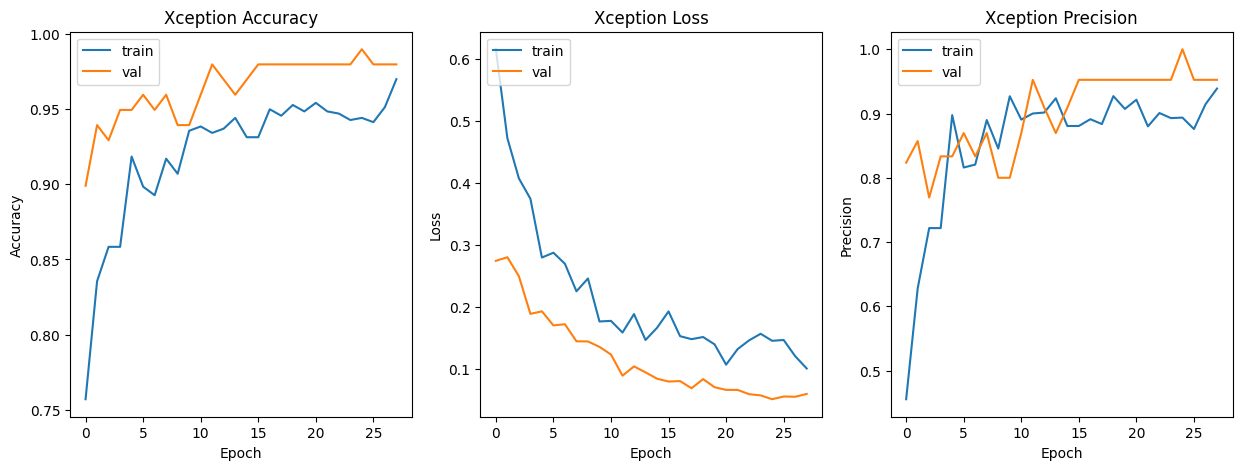

In [ ]:
plot_history(Xception_history, 'Xception')

**InceptionV3**

In [ ]:
InceptionV3_base = tf.keras.applications.InceptionV3(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in InceptionV3_base.layers:
    layer.trainable = False

InceptionV3=tf.keras.Sequential()
InceptionV3.add(InceptionV3_base)
InceptionV3.add(tf.keras.layers.Dropout(0.5))
InceptionV3.add(tf.keras.layers.Flatten())
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Activation('relu'))
InceptionV3.add(tf.keras.layers.Dropout(0.5))
InceptionV3.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Activation('relu'))
InceptionV3.add(tf.keras.layers.Dropout(0.5))
InceptionV3.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Activation('relu'))
InceptionV3.add(tf.keras.layers.Dense(1,activation='sigmoid'))

InceptionV3.summary()

InceptionV3.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout_9 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 batch_normalization_110 (B  (None, 51200)             204800    
 atchNormalization)                                              
                                                                 
 dense_12 (Dense)            (None, 32)                1638432   
                                                                 
 batch_normalization_111 (B  (None, 32)                

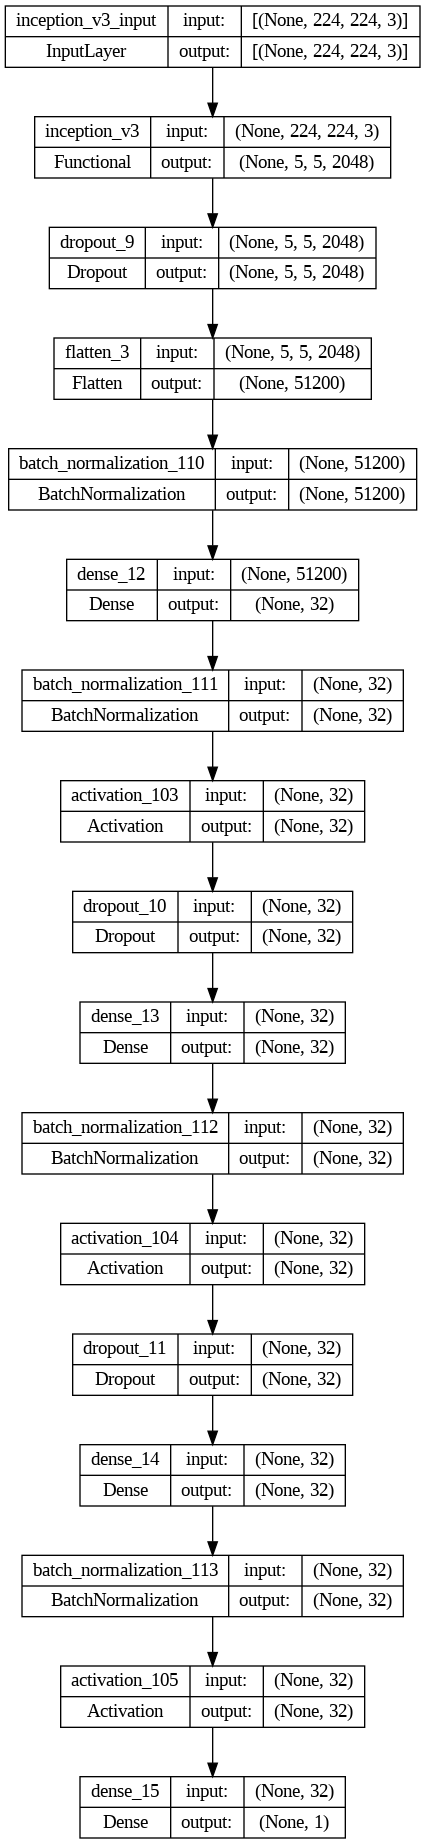

In [ ]:
tf.keras.utils.plot_model(InceptionV3, to_file='./InceptionV3.png', show_shapes=True,show_layer_names=True)
Image(filename='InceptionV3.png')

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('InceptionV3.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

InceptionV3_history = InceptionV3.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.6634 - Accuracy: 0.6948 - Precision: 0.3937 - Recall: 0.7732 - AUC: 0.8364 - F1: 0.4452

22/22 [==============================] - 25s 768ms/step - loss: 0.6634 - Accuracy: 0.6948 - Precision: 0.3937 - Recall: 0.7732 - AUC: 0.8364 - F1: 0.4452 - val_loss: 0.1451 - val_Accuracy: 0.9394 - val_Precision: 0.8947 - val_Recall: 0.8095 - val_AUC: 0.9744 - val_F1: 0.6415 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.5186 - Accuracy: 0.7768 - Precision: 0.4858 - Recall: 0.6867 - AUC: 0.8127 - F1: 0.5513

22/22 [==============================] - 12s 551ms/step - loss: 0.5186 - Accuracy: 0.7768 - Precision: 0.4858 - Recall: 0.6867 - AUC: 0.8127 - F1: 0.5513 - val_loss: 0.1889 - val_Accuracy: 0.9394 - val_Precision: 0.8000 - val_Recall: 0.9524 - val_AUC: 0.9844 - val_F1: 0.9001 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4500 - Accuracy: 0.8555 - Precision: 0.6667 - Recall: 0.6533 - AUC: 0.8509 - F1: 0.6421

22/22 [==============================] - 13s 582ms/step - loss: 0.4500 - Accuracy: 0.8555 - Precision: 0.6667 - Recall: 0.6533 - AUC: 0.8509 - F1: 0.6421 - val_loss: 0.1777 - val_Accuracy: 0.9495 - val_Precision: 0.8333 - val_Recall: 0.9524 - val_AUC: 0.9921 - val_F1: 0.6556 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.3795 - Accuracy: 0.8741 - Precision: 0.7348 - Recall: 0.6467 - AUC: 0.8878 - F1: 0.6737
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 13s 572ms/step - loss: 0.3795 - Accuracy: 0.8741 - Precision: 0.7348 - Recall: 0.6467 - AUC: 0.8878 - F1: 0.6737 - val_loss: 0.1868 - val_Accuracy: 0.9596 - val_Precision: 0.8696 - val_Recall: 0.9524 - val_AUC: 0.9957 - val_F1: 0.6828 - lr: 0.0010
Epoch 4: early stopping


In [ ]:
InceptionV3_scores = InceptionV3.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 3s 441ms/step - loss: 0.1708 - Accuracy: 0.9455 - Precision: 0.8000 - Recall: 1.0000 - AUC: 0.9977 - F1: 0.8718


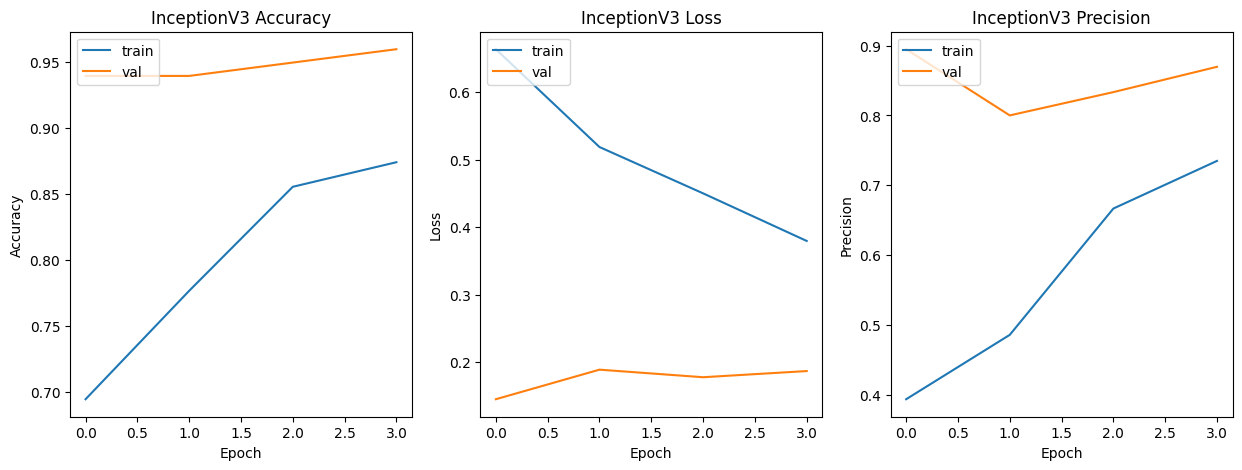

In [ ]:
plot_history(InceptionV3_history, 'InceptionV3')

**ResNet50**

In [ ]:
ResNet50_base = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in ResNet50_base.layers:
    layer.trainable = False

ResNet50=tf.keras.Sequential()
ResNet50.add(ResNet50_base)
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Flatten())
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dense(1,activation='sigmoid'))

ResNet50.summary()

ResNet50.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_114 (B  (None, 100352)            401408    
 atchNormalization)                                              
                                                                 
 dense_16 (Dense)            (None, 32)                3211296   
                                                                 
 batch_normalization_115 (B  (None, 32)                

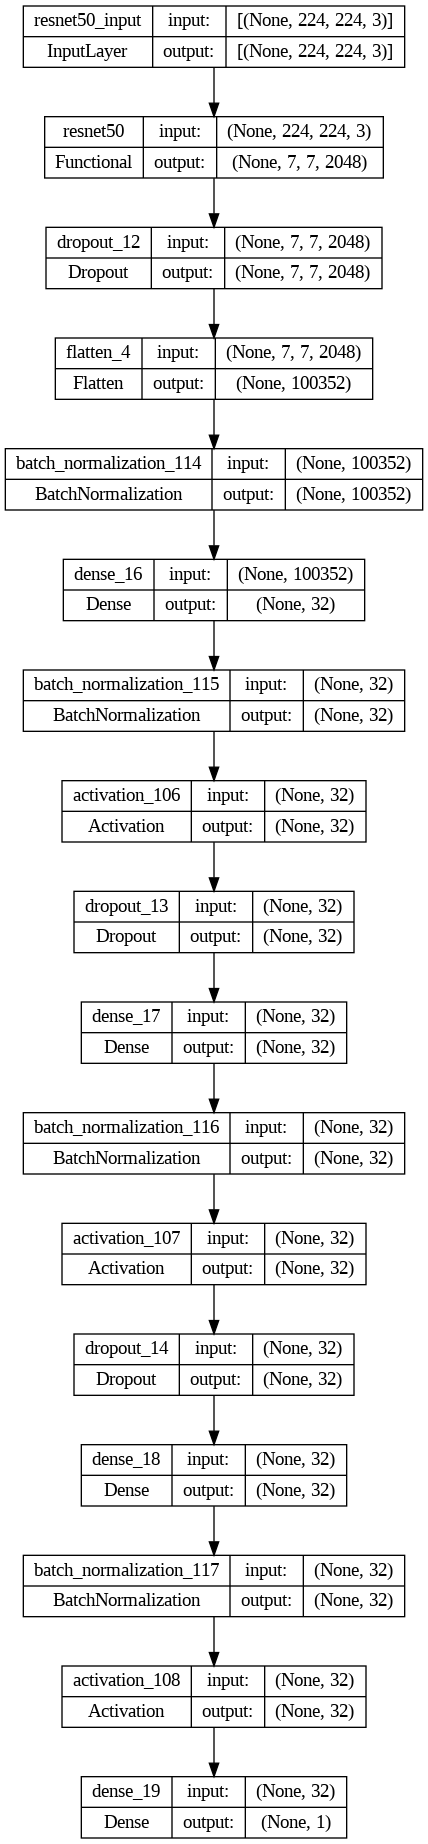

In [ ]:
tf.keras.utils.plot_model(ResNet50, to_file='./ResNet50.png', show_shapes=True,show_layer_names=True)
Image(filename='ResNet50.png')

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('ResNet50.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

ResNet50_history = ResNet50.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.6133 - Accuracy: 0.7203 - Precision: 0.3885 - Recall: 0.5206 - AUC: 0.7411 - F1: 0.3159

22/22 [==============================] - 21s 706ms/step - loss: 0.6133 - Accuracy: 0.7203 - Precision: 0.3885 - Recall: 0.5206 - AUC: 0.7411 - F1: 0.3159 - val_loss: 1.0346 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.7164 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.5350 - Accuracy: 0.7582 - Precision: 0.4174 - Recall: 0.3200 - AUC: 0.6807 - F1: 0.3651

22/22 [==============================] - 12s 541ms/step - loss: 0.5350 - Accuracy: 0.7582 - Precision: 0.4174 - Recall: 0.3200 - AUC: 0.6807 - F1: 0.3651 - val_loss: 0.7047 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8428 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.5127 - Accuracy: 0.7797 - Precision: 0.4722 - Recall: 0.2267 - AUC: 0.6787 - F1: 0.2876

22/22 [==============================] - 13s 578ms/step - loss: 0.5127 - Accuracy: 0.7797 - Precision: 0.4722 - Recall: 0.2267 - AUC: 0.6787 - F1: 0.2876 - val_loss: 0.5484 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.9136 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4776 - Accuracy: 0.7983 - Precision: 0.6216 - Recall: 0.1533 - AUC: 0.7273 - F1: 0.2214

22/22 [==============================] - 13s 571ms/step - loss: 0.4776 - Accuracy: 0.7983 - Precision: 0.6216 - Recall: 0.1533 - AUC: 0.7273 - F1: 0.2214 - val_loss: 0.3903 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.9258 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.4416 - Accuracy: 0.8069 - Precision: 0.6415 - Recall: 0.2267 - AUC: 0.7936 - F1: 0.3147

22/22 [==============================] - 13s 576ms/step - loss: 0.4416 - Accuracy: 0.8069 - Precision: 0.6415 - Recall: 0.2267 - AUC: 0.7936 - F1: 0.3147 - val_loss: 0.3857 - val_Accuracy: 0.7778 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8858 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.4316 - Accuracy: 0.7997 - Precision: 0.6316 - Recall: 0.1600 - AUC: 0.7855 - F1: 0.2402

22/22 [==============================] - 13s 576ms/step - loss: 0.4316 - Accuracy: 0.7997 - Precision: 0.6316 - Recall: 0.1600 - AUC: 0.7855 - F1: 0.2402 - val_loss: 0.2968 - val_Accuracy: 0.8283 - val_Precision: 0.8333 - val_Recall: 0.2381 - val_AUC: 0.9420 - val_F1: 0.4514 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.4391 - Accuracy: 0.8197 - Precision: 0.7400 - Recall: 0.2467 - AUC: 0.7756 - F1: 0.3561

22/22 [==============================] - 13s 582ms/step - loss: 0.4391 - Accuracy: 0.8197 - Precision: 0.7400 - Recall: 0.2467 - AUC: 0.7756 - F1: 0.3561 - val_loss: 0.2986 - val_Accuracy: 0.8687 - val_Precision: 0.7857 - val_Recall: 0.5238 - val_AUC: 0.9414 - val_F1: 0.7219 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.4191 - Accuracy: 0.8255 - Precision: 0.7917 - Recall: 0.2533 - AUC: 0.7967 - F1: 0.3703

22/22 [==============================] - 13s 581ms/step - loss: 0.4191 - Accuracy: 0.8255 - Precision: 0.7917 - Recall: 0.2533 - AUC: 0.7967 - F1: 0.3703 - val_loss: 0.2995 - val_Accuracy: 0.8384 - val_Precision: 0.7778 - val_Recall: 0.3333 - val_AUC: 0.9295 - val_F1: 0.3582 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.4024 - Accuracy: 0.8169 - Precision: 0.6964 - Recall: 0.2600 - AUC: 0.8212 - F1: 0.3478

22/22 [==============================] - 13s 587ms/step - loss: 0.4024 - Accuracy: 0.8169 - Precision: 0.6964 - Recall: 0.2600 - AUC: 0.8212 - F1: 0.3478 - val_loss: 0.2764 - val_Accuracy: 0.9091 - val_Precision: 0.8333 - val_Recall: 0.7143 - val_AUC: 0.9249 - val_F1: 0.5800 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.4093 - Accuracy: 0.8340 - Precision: 0.7500 - Recall: 0.3400 - AUC: 0.8152 - F1: 0.4462

22/22 [==============================] - 12s 550ms/step - loss: 0.4093 - Accuracy: 0.8340 - Precision: 0.7500 - Recall: 0.3400 - AUC: 0.8152 - F1: 0.4462 - val_loss: 0.2812 - val_Accuracy: 0.8990 - val_Precision: 0.7895 - val_Recall: 0.7143 - val_AUC: 0.9203 - val_F1: 0.5511 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.3946 - Accuracy: 0.8326 - Precision: 0.7200 - Recall: 0.3600 - AUC: 0.8257 - F1: 0.4596

22/22 [==============================] - 12s 547ms/step - loss: 0.3946 - Accuracy: 0.8326 - Precision: 0.7200 - Recall: 0.3600 - AUC: 0.8257 - F1: 0.4596 - val_loss: 0.2779 - val_Accuracy: 0.8889 - val_Precision: 0.8125 - val_Recall: 0.6190 - val_AUC: 0.9252 - val_F1: 0.5026 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.3837 - Accuracy: 0.8312 - Precision: 0.6860 - Recall: 0.3933 - AUC: 0.8413 - F1: 0.4776

22/22 [==============================] - 13s 581ms/step - loss: 0.3837 - Accuracy: 0.8312 - Precision: 0.6860 - Recall: 0.3933 - AUC: 0.8413 - F1: 0.4776 - val_loss: 0.2463 - val_Accuracy: 0.9091 - val_Precision: 0.8333 - val_Recall: 0.7143 - val_AUC: 0.9390 - val_F1: 0.6964 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.3600 - Accuracy: 0.8240 - Precision: 0.6552 - Recall: 0.3800 - AUC: 0.8674 - F1: 0.4672

22/22 [==============================] - 13s 590ms/step - loss: 0.3600 - Accuracy: 0.8240 - Precision: 0.6552 - Recall: 0.3800 - AUC: 0.8674 - F1: 0.4672 - val_loss: 0.2184 - val_Accuracy: 0.8990 - val_Precision: 0.7895 - val_Recall: 0.7143 - val_AUC: 0.9646 - val_F1: 0.5695 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.3483 - Accuracy: 0.8398 - Precision: 0.7375 - Recall: 0.3933 - AUC: 0.8738 - F1: 0.5066

22/22 [==============================] - 13s 594ms/step - loss: 0.3483 - Accuracy: 0.8398 - Precision: 0.7375 - Recall: 0.3933 - AUC: 0.8738 - F1: 0.5066 - val_loss: 0.2018 - val_Accuracy: 0.9091 - val_Precision: 0.8333 - val_Recall: 0.7143 - val_AUC: 0.9713 - val_F1: 0.8013 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.3613 - Accuracy: 0.8455 - Precision: 0.7143 - Recall: 0.4667 - AUC: 0.8564 - F1: 0.5531

22/22 [==============================] - 13s 577ms/step - loss: 0.3613 - Accuracy: 0.8455 - Precision: 0.7143 - Recall: 0.4667 - AUC: 0.8564 - F1: 0.5531 - val_loss: 0.1964 - val_Accuracy: 0.9192 - val_Precision: 0.8421 - val_Recall: 0.7619 - val_AUC: 0.9713 - val_F1: 0.8056 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.3473 - Accuracy: 0.8526 - Precision: 0.7474 - Recall: 0.4733 - AUC: 0.8692 - F1: 0.5626

22/22 [==============================] - 13s 582ms/step - loss: 0.3473 - Accuracy: 0.8526 - Precision: 0.7474 - Recall: 0.4733 - AUC: 0.8692 - F1: 0.5626 - val_loss: 0.1934 - val_Accuracy: 0.9091 - val_Precision: 0.8333 - val_Recall: 0.7143 - val_AUC: 0.9713 - val_F1: 0.8201 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.3392 - Accuracy: 0.8598 - Precision: 0.7600 - Recall: 0.5067 - AUC: 0.8768 - F1: 0.6018

22/22 [==============================] - 13s 592ms/step - loss: 0.3392 - Accuracy: 0.8598 - Precision: 0.7600 - Recall: 0.5067 - AUC: 0.8768 - F1: 0.6018 - val_loss: 0.2065 - val_Accuracy: 0.8889 - val_Precision: 0.7500 - val_Recall: 0.7143 - val_AUC: 0.9661 - val_F1: 0.5688 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.3536 - Accuracy: 0.8469 - Precision: 0.7129 - Recall: 0.4800 - AUC: 0.8690 - F1: 0.5479

22/22 [==============================] - 13s 592ms/step - loss: 0.3536 - Accuracy: 0.8469 - Precision: 0.7129 - Recall: 0.4800 - AUC: 0.8690 - F1: 0.5479 - val_loss: 0.2301 - val_Accuracy: 0.8788 - val_Precision: 0.7143 - val_Recall: 0.7143 - val_AUC: 0.9609 - val_F1: 0.5485 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.3396 - Accuracy: 0.8655 - Precision: 0.7642 - Recall: 0.5400 - AUC: 0.8755 - F1: 0.6238
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 13s 570ms/step - loss: 0.3396 - Accuracy: 0.8655 - Precision: 0.7642 - Recall: 0.5400 - AUC: 0.8755 - F1: 0.6238 - val_loss: 0.2358 - val_Accuracy: 0.9091 - val_Precision: 0.8000 - val_Recall: 0.7619 - val_AUC: 0.9438 - val_F1: 0.8167 - lr: 0.0010
Epoch 19: early stopping


In [ ]:
ResNet50_scores = ResNet50.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 2s 315ms/step - loss: 0.1482 - Accuracy: 0.9653 - Precision: 0.9111 - Recall: 0.9318 - AUC: 0.9793 - F1: 0.9259


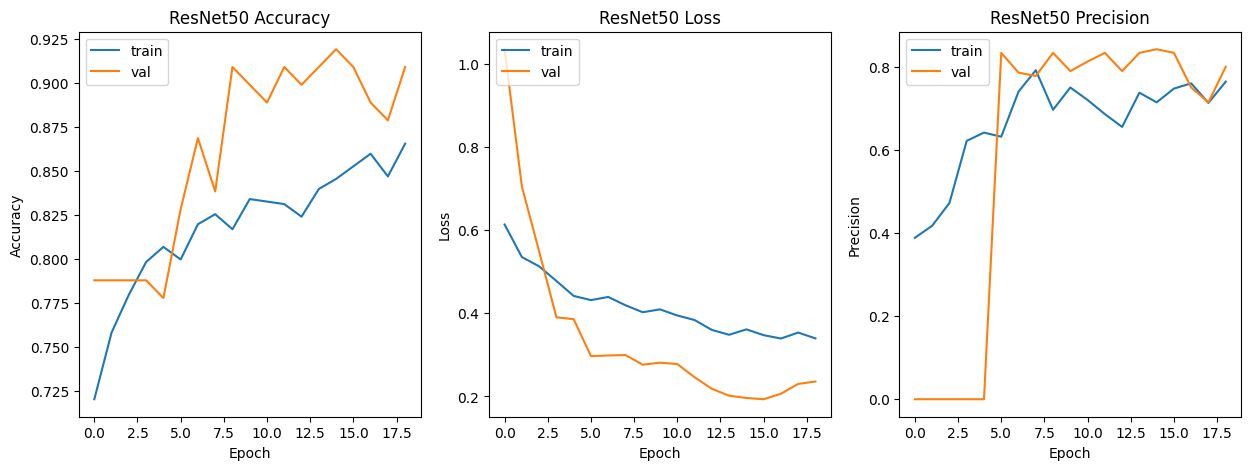

In [ ]:
plot_history(ResNet50_history, 'ResNet50')

**Example: Prediction vs Truth**

1/1 [==============================] - 0s 217ms/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 22ms/step


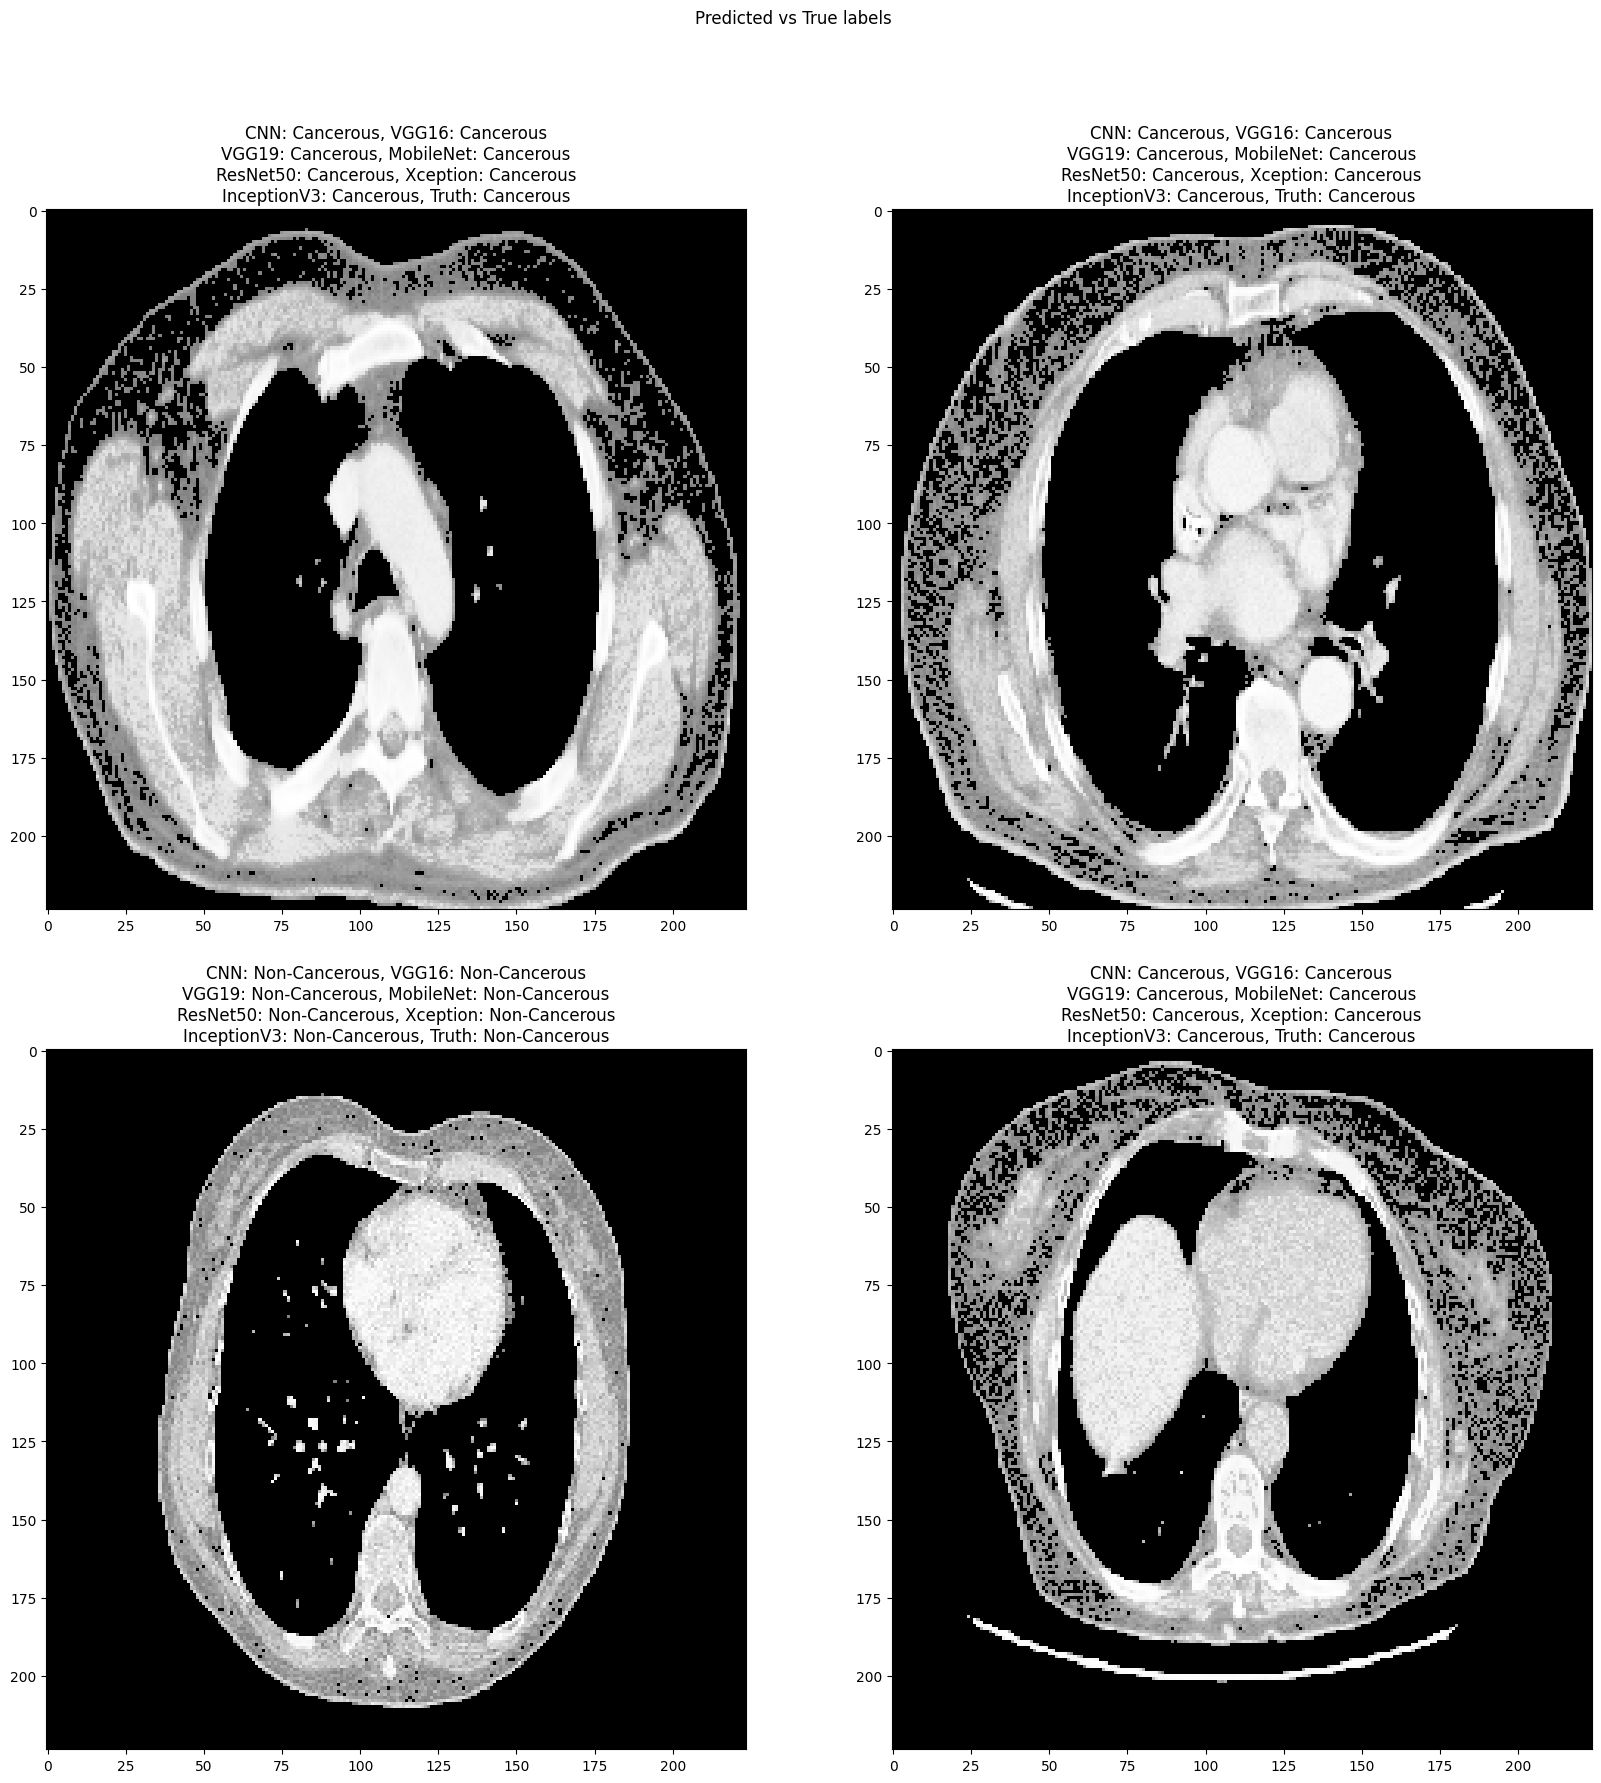

In [ ]:
batch = next(test_dataset)

def predAll(batch, i):
  label_dict = {0: 'Cancerous', 1: 'Non-Cancerous'}
  cnnPred = 0 if CNN.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  vgg16Pred = 0 if VGG16.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  mobilenetPred = 0 if MOBILENET.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  vgg19Pred = 0 if VGG19.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  xceptionPred = 0 if Xception.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  inceptionv3Pred = 0 if InceptionV3.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  resnet50Pred = 0 if ResNet50.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1

  return f'CNN: {label_dict[cnnPred]}, VGG16: {label_dict[vgg16Pred]}\nVGG19: {label_dict[vgg19Pred]}, MobileNet: {label_dict[mobilenetPred]}\nResNet50: {label_dict[resnet50Pred]}, Xception: {label_dict[xceptionPred]}\nInceptionV3: {label_dict[inceptionv3Pred]}, Truth: {label_dict[int(batch[1][i])]}'


plt.figure(figsize=(20, 20))

ax1 = plt.subplot(2, 2, 1)
plt.imshow(batch[0][0])
label = predAll(batch, 0)
ax1.set_title(label)


ax2 = plt.subplot(2, 2, 2)
plt.imshow(batch[0][5])
label = predAll(batch, 1)
ax2.set_title(label)

ax3 = plt.subplot(2, 2, 3)
plt.imshow(batch[0][2])
label = predAll(batch, 2)
ax3.set_title(label)

ax4 = plt.subplot(2, 2, 4)
plt.imshow(batch[0][3])
label = predAll(batch, 3)
ax4.set_title(label)


plt.suptitle('Predicted vs True labels')
plt.show()


In [ ]:
eval = [CNN_scores, VGG16_scores, VGG19_scores, MOBILENET_scores, ResNet50_scores, Xception_scores, InceptionV3_scores]
eval

[[0.1729074865579605,
  0.9504950642585754,
  0.8399999737739563,
  0.9545454382896423,
  0.9877732396125793,
  0.8810645937919617],
 [0.030548403039574623,
  0.9950494766235352,
  0.9777777791023254,
  1.0,
  1.0,
  0.9931973218917847],
 [0.06475991755723953,
  0.9801980257034302,
  0.976190447807312,
  0.9318181872367859,
  0.9958285093307495,
  0.9546335935592651],
 [0.020902162417769432,
  0.9900990128517151,
  0.9772727489471436,
  0.9772727489471436,
  0.9998562335968018,
  0.9700680375099182],
 [0.14821885526180267,
  0.9653465151786804,
  0.9111111164093018,
  0.9318181872367859,
  0.9792864918708801,
  0.9258503317832947],
 [0.014583290554583073, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.1708245426416397,
  0.9455445408821106,
  0.800000011920929,
  1.0,
  0.9976985454559326,
  0.8718282580375671]]

**Comparative analysis of the models**

In [ ]:
indices = ['CNN', 'VGG16', 'VGG19', 'MobileNet', 'ResNet', 'Xception', 'InceptionV3']
scores = pd.DataFrame({'Accuracy': [item[1] for item in eval],'Precision': [item[2] for item in eval], 'Recall': [item[3] for item in eval], 'AUC': [item[4] for item in eval], 'F1': [item[5] for item in eval]}, index=indices)
scores

,Accuracy,Precision,Recall,AUC,F1
CNN,0.950495,0.840000,0.954545,0.987773,0.881065
VGG16,0.995049,0.977778,1.000000,1.000000,0.993197
VGG19,0.980198,0.976190,0.931818,0.995829,0.954634
MobileNet,0.990099,0.977273,0.977273,0.999856,0.970068
ResNet,0.965347,0.911111,0.931818,0.979286,0.925850
Xception,1.000000,1.000000,1.000000,1.000000,1.000000
InceptionV3,0.945545,0.800000,1.000000,0.997699,0.871828


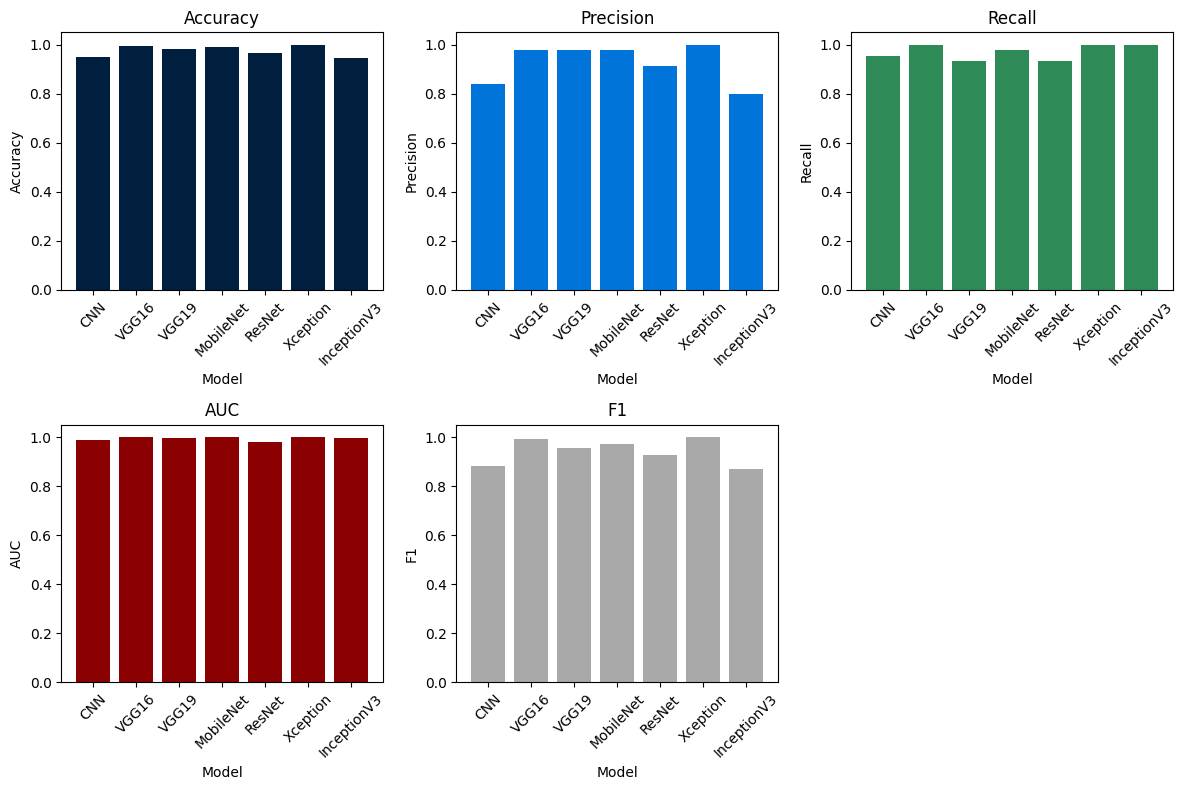

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs = axs.ravel()

colors = ['#001f3f', '#0074D9', '#2E8B57', '#8B0000', '#A9A9A9']

for i, column in enumerate(scores.columns):
    axs[i].bar(scores.index, scores[column], color=colors[i])
    axs[i].set_xlabel('Model')
    axs[i].set_ylabel(column)
    axs[i].set_title(f'{column}')
    axs[i].tick_params(axis='x', rotation=45)

for i in range(len(scores.columns), len(axs)):
    plt.delaxes(axs[i])

plt.tight_layout()
plt.show()


In [ ]:
eval = np.array(eval)
np.savetxt('eval.txt', eval)